In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error
from itertools import product
from sklearn.metrics import mean_absolute_error

In [2]:
df = pd.read_csv("full_store_trans.csv",index_col="date")
df.head()

store_nbr  store_promo sto_type  cluster holi_type locale  year  \
date                                                                          
2013-01-02          1            0        D       13       NaN    NaN  2013   
2013-01-02         10            0        C       15       NaN    NaN  2013   
2013-01-02         17            0        C       12       NaN    NaN  2013   
2013-01-02          2            0        D       13       NaN    NaN  2013   
2013-01-02         20            0        B        6       NaN    NaN  2013   

            month  day  dcoilwtico_interpolated  store_trans_filled  weekday  \
date                                                                           
2013-01-02      1    2                    93.14              2111.0        3   
2013-01-02      1    2                    93.14              1293.0        3   
2013-01-02      1    2                    93.14              1580.0        3   
2013-01-02      1    2                    93.14              2358.0        3   
2013-01-02      1    2                    93.14                 NaN        3   

            weekend  
date                 
2013-01-02        0  
2013-01-02        0  
2013-01-02        0  
2013-01-02        0  
2013-01-02        0

In [6]:
df = df.drop(columns=['sto_type','cluster','holi_type','locale'])

In [7]:
df = df.reset_index()
df.head()

date  store_nbr  store_promo  year  month  day  \
0  2013-01-02          1            0  2013      1    2   
1  2013-01-02         10            0  2013      1    2   
2  2013-01-02         17            0  2013      1    2   
3  2013-01-02          2            0  2013      1    2   
4  2013-01-02         20            0  2013      1    2   

   dcoilwtico_interpolated  store_trans_filled  weekday  weekend  
0                    93.14              2111.0        3        0  
1                    93.14              1293.0        3        0  
2                    93.14              1580.0        3        0  
3                    93.14              2358.0        3        0  
4                    93.14                 NaN        3        0

In [8]:
# remove duplicated rows
df = df.drop_duplicates()

In [9]:
df.isna().sum()

date                         0
store_nbr                    0
store_promo                  0
year                         0
month                        0
day                          0
dcoilwtico_interpolated      0
store_trans_filled         770
weekday                      0
weekend                      0
dtype: int64

In [10]:
df['date'] = pd.to_datetime(df['date'])
print(df['date'].dtype)

datetime64[ns]


In [11]:
full_date_range = pd.date_range(start=df['date'].min(), end=df['date'].max())

# Step 2: Create a multi-index with all combinations of store_nbr and the full date range
full_index = pd.MultiIndex.from_product([df['store_nbr'].unique(), full_date_range], names=['store_nbr', 'date'])

# Step 3: Reindex the DataFrame with this full index
df = df.set_index(['store_nbr', 'date']).reindex(full_index)

In [12]:
df=df.reset_index()
df 

store_nbr       date  store_promo    year  month   day  \
0              1 2013-01-02          0.0  2013.0    1.0   2.0   
1              1 2013-01-03          0.0  2013.0    1.0   3.0   
2              1 2013-01-04          0.0  2013.0    1.0   4.0   
3              1 2013-01-05          0.0  2013.0    1.0   5.0   
4              1 2013-01-06          0.0  2013.0    1.0   6.0   
...          ...        ...          ...     ...    ...   ...   
28674          9 2017-08-11        279.0  2017.0    8.0  11.0   
28675          9 2017-08-12        214.0  2017.0    8.0  12.0   
28676          9 2017-08-13        261.0  2017.0    8.0  13.0   
28677          9 2017-08-14        203.0  2017.0    8.0  14.0   
28678          9 2017-08-15        331.0  2017.0    8.0  15.0   

       dcoilwtico_interpolated  store_trans_filled  weekday  weekend  
0                    93.140000              2111.0      3.0      0.0  
1                    92.970000              1833.0      4.0      0.0  
2                    93.120000              1863.0      5.0      0.0  
3                    93.146667              1509.0      0.0      1.0  
4                    93.173333               520.0      0.0      1.0  
...                        ...                 ...      ...      ...  
28674                48.810000              1848.0      5.0      0.0  
28675                48.403333              1920.0      0.0      1.0  
28676                47.996667              1745.0      0.0      1.0  
28677                47.590000              1971.0      1.0      0.0  
28678                47.570000              2155.0      2.0      0.0  

[28679 rows x 10 columns]

#### From previous analysis, we know that store 20 opend in 2015 while other stores opend in 2013, so I need to drop the rows when store 20 didn't open before filling nulls.

In [14]:
# check when store 20 opened
filtered_df = df[(df.store_nbr == 20) & (df.store_trans_filled.notnull())]
filtered_df

store_nbr       date  store_promo    year  month   day  \
7520         20 2015-02-13         22.0  2015.0    2.0  13.0   
7521         20 2015-02-14         13.0  2015.0    2.0  14.0   
7522         20 2015-02-15         10.0  2015.0    2.0  15.0   
7523         20 2015-02-16         11.0  2015.0    2.0  16.0   
7524         20 2015-02-17         18.0  2015.0    2.0  17.0   
...         ...        ...          ...     ...    ...   ...   
8430         20 2017-08-11        279.0  2017.0    8.0  11.0   
8431         20 2017-08-12        213.0  2017.0    8.0  12.0   
8432         20 2017-08-13        264.0  2017.0    8.0  13.0   
8433         20 2017-08-14        206.0  2017.0    8.0  14.0   
8434         20 2017-08-15        306.0  2017.0    8.0  15.0   

      dcoilwtico_interpolated  store_trans_filled  weekday  weekend  
7520                52.660000              4500.0      5.0      0.0  
7521                52.960000              3698.0      0.0      1.0  
7522                53.260000              3181.0      0.0      1.0  
7523                53.560000              2915.0      1.0      0.0  
7524                53.560000              2826.0      2.0      0.0  
...                       ...                 ...      ...      ...  
8430                48.810000              1751.0      5.0      0.0  
8431                48.403333              1664.0      0.0      1.0  
8432                47.996667              1834.0      0.0      1.0  
8433                47.590000              1522.0      1.0      0.0  
8434                47.570000              1516.0      2.0      0.0  

[913 rows x 10 columns]

In [15]:
# filter the rows when store 20 didn't open
df = df[~((df.store_nbr == 20) & (df.date < '2015-02-13'))]
# reset date as index
df = df.set_index('date')
df.head()

store_nbr  store_promo    year  month  day  \
date                                                     
2013-01-02          1          0.0  2013.0    1.0  2.0   
2013-01-03          1          0.0  2013.0    1.0  3.0   
2013-01-04          1          0.0  2013.0    1.0  4.0   
2013-01-05          1          0.0  2013.0    1.0  5.0   
2013-01-06          1          0.0  2013.0    1.0  6.0   

            dcoilwtico_interpolated  store_trans_filled  weekday  weekend  
date                                                                       
2013-01-02                93.140000              2111.0      3.0      0.0  
2013-01-03                92.970000              1833.0      4.0      0.0  
2013-01-04                93.120000              1863.0      5.0      0.0  
2013-01-05                93.146667              1509.0      0.0      1.0  
2013-01-06                93.173333               520.0      0.0      1.0

In [18]:
# check for store number
df.store_nbr.nunique()

17

In [19]:
# check for nulls
df.isna().sum()

store_nbr                   0
store_promo                66
year                       66
month                      66
day                        66
dcoilwtico_interpolated    66
store_trans_filled         66
weekday                    66
weekend                    66
dtype: int64

#### The number of null values match with 16 stores' null values on Christmas Day. Now let's fill the nulls.

In [20]:
# Create a list of unique store numbers
stores = list(df.store_nbr.unique())

# Loop through each store number
for s in stores:
    # Filter data for the current store and fill missing values
    df.loc[df.store_nbr == s, 'dcoilwtico_interpolated'] = df.loc[df.store_nbr == s, 'dcoilwtico_interpolated'].ffill()
    df.loc[df.store_nbr == s, ['store_promo', 'store_trans_filled']] = df.loc[df.store_nbr == s, ['store_promo', 'store_trans_filled']].fillna(0)
    
    # Create Series for date-related columns from index
    year_series = pd.Series(df.loc[df.store_nbr == s].index.year, index=df.loc[df.store_nbr == s].index)
    month_series = pd.Series(df.loc[df.store_nbr == s].index.month, index=df.loc[df.store_nbr == s].index)
    day_series = pd.Series(df.loc[df.store_nbr == s].index.day, index=df.loc[df.store_nbr == s].index)
    weekday_series = pd.Series(df.loc[df.store_nbr == s].index.weekday, index=df.loc[df.store_nbr == s].index)
    
    # Fill missing values for date-related columns
    df.loc[df.store_nbr == s, 'year'] = df.loc[df.store_nbr == s, 'year'].fillna(year_series)
    df.loc[df.store_nbr == s, 'month'] = df.loc[df.store_nbr == s, 'month'].fillna(month_series)
    df.loc[df.store_nbr == s, 'day'] = df.loc[df.store_nbr == s, 'day'].fillna(day_series)
    df.loc[df.store_nbr == s, 'weekday'] = df.loc[df.store_nbr == s, 'weekday'].fillna(weekday_series)
    
    # Update the weekend column based on weekday
    df.loc[(df.store_nbr == s) & (df['weekday'] > 5), 'weekday'] = 0
    df.loc[(df.store_nbr == s) & (df['weekday'] <= 5), 'weekend'] = 0
    df.loc[(df.store_nbr == s) & (df['weekday'] == 0), 'weekend'] = 1

In [21]:
# sanity check
df.isna().sum()

store_nbr                  0
store_promo                0
year                       0
month                      0
day                        0
dcoilwtico_interpolated    0
store_trans_filled         0
weekday                    0
weekend                    0
dtype: int64

In [22]:
# Create 'lag365' as exogenous feature
for s in stores:
    # Filter data for the current store and fill missing values
    df.loc[df.store_nbr == s, 'lag365'] = df.loc[df.store_nbr == s, 'store_trans_filled'].shift(365)
# Drop null values
df = df.dropna()
df

store_nbr  store_promo    year  month   day  \
date                                                      
2014-01-02          1          0.0  2014.0    1.0   2.0   
2014-01-03          1          0.0  2014.0    1.0   3.0   
2014-01-04          1          0.0  2014.0    1.0   4.0   
2014-01-05          1          0.0  2014.0    1.0   5.0   
2014-01-06          1          0.0  2014.0    1.0   6.0   
...               ...          ...     ...    ...   ...   
2017-08-11          9        279.0  2017.0    8.0  11.0   
2017-08-12          9        214.0  2017.0    8.0  12.0   
2017-08-13          9        261.0  2017.0    8.0  13.0   
2017-08-14          9        203.0  2017.0    8.0  14.0   
2017-08-15          9        331.0  2017.0    8.0  15.0   

            dcoilwtico_interpolated  store_trans_filled  weekday  weekend  \
date                                                                        
2014-01-02                95.140000              1875.0      4.0      0.0   
2014-01-03                93.660000              1817.0      5.0      0.0   
2014-01-04                93.480000              1294.0      0.0      1.0   
2014-01-05                93.300000               489.0      0.0      1.0   
2014-01-06                93.120000              1754.0      1.0      0.0   
...                             ...                 ...      ...      ...   
2017-08-11                48.810000              1848.0      5.0      0.0   
2017-08-12                48.403333              1920.0      0.0      1.0   
2017-08-13                47.996667              1745.0      0.0      1.0   
2017-08-14                47.590000              1971.0      1.0      0.0   
2017-08-15                47.570000              2155.0      2.0      0.0   

            lag365  
date                
2014-01-02  2111.0  
2014-01-03  1833.0  
2014-01-04  1863.0  
2014-01-05  1509.0  
2014-01-06   520.0  
...            ...  
2017-08-11  1887.0  
2017-08-12  1976.0  
2017-08-13  1882.0  
2017-08-14  1812.0  
2017-08-15  1999.0  

[21702 rows x 10 columns]

### Check for data stationarity

In [259]:
df_train = df[df.index < '2017-01-01']
df_test = df[df.index >= '2017-01-01']

In [260]:
# Loop through each store to check for stationarity and determine the 'd' value
for s in stores:
    d = 0
    # Perform ADF test on the original series
    result = adfuller(df_train.loc[df_train['store_nbr'] == s, "store_trans_filled"])
    
    if result[1] <= 0.05:
        print(f'Store {s} is stationary, d={d}')
    else:
        d += 1
        # Perform ADF test on the differenced series
        result = adfuller(df_train.loc[df_train['store_nbr'] == s, "store_trans_filled"].diff(1).dropna())
        
        if result[1] <= 0.05:
            print(f'Store {s} is stationary after first differencing, d={d}')
        else:
            d += 1
            print(f'Store {s} is not stationary after first differencing, further differencing might be needed, d={d}')

Store 1 is stationary, d=0
Store 10 is stationary, d=0
Store 17 is stationary after first differencing, d=1
Store 2 is stationary, d=0
Store 20 is stationary after first differencing, d=1
Store 3 is stationary, d=0
Store 4 is stationary, d=0
Store 44 is stationary, d=0
Store 45 is stationary, d=0
Store 46 is stationary, d=0
Store 47 is stationary, d=0
Store 48 is stationary, d=0
Store 49 is stationary, d=0
Store 6 is stationary, d=0
Store 7 is stationary, d=0
Store 8 is stationary, d=0
Store 9 is stationary, d=0


#### We can see that store 17 and 20 need one time differencing and other stores are stationary without differencing.

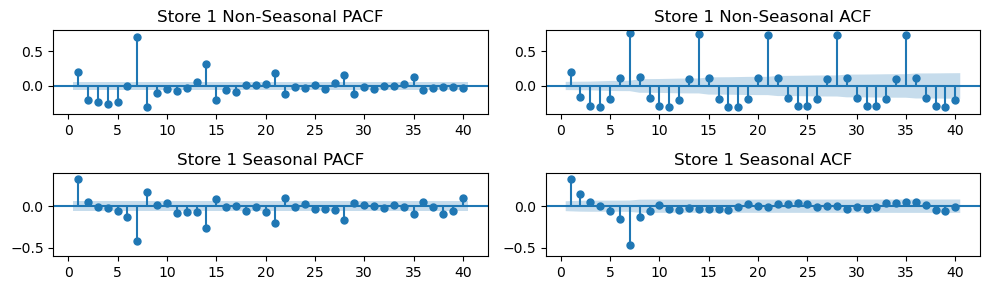

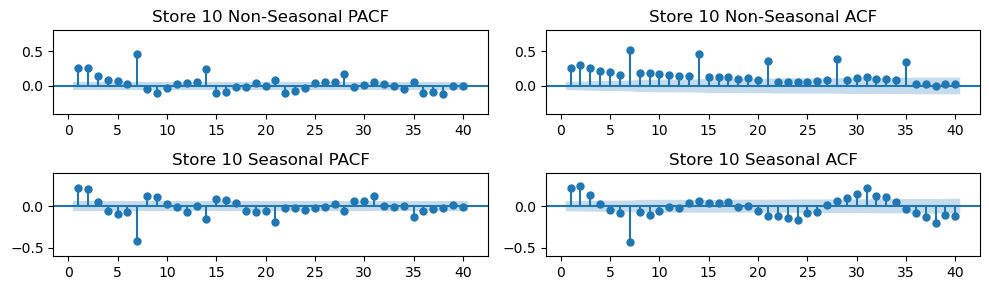

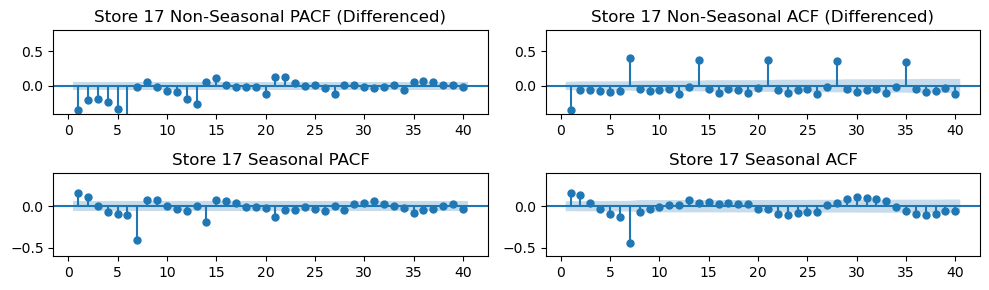

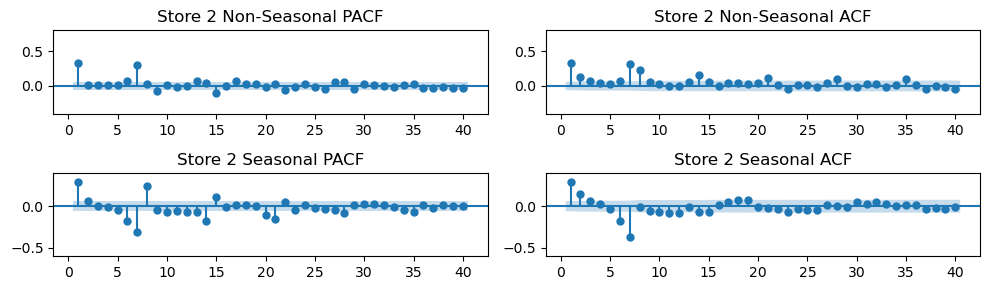

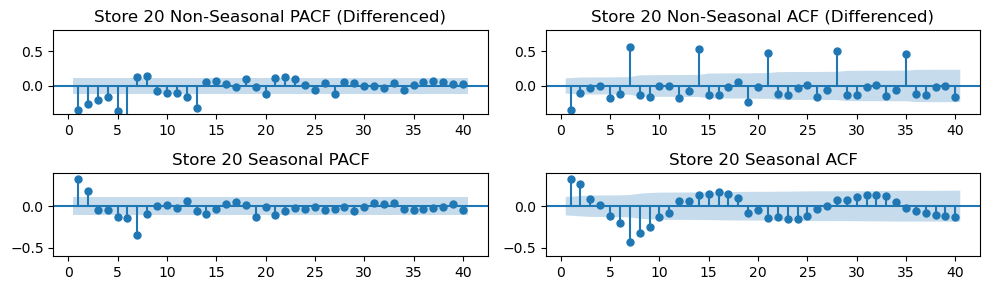

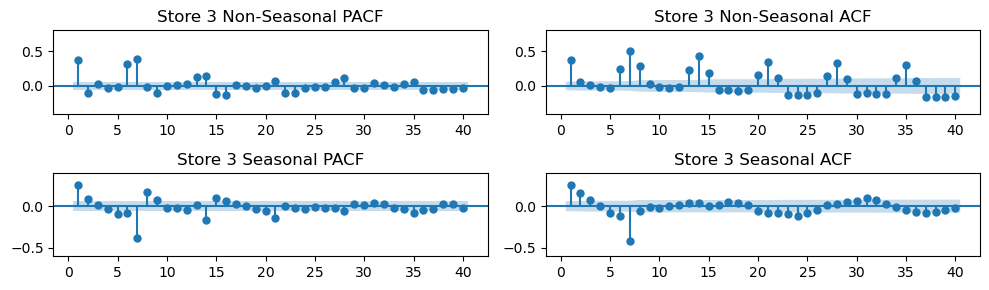

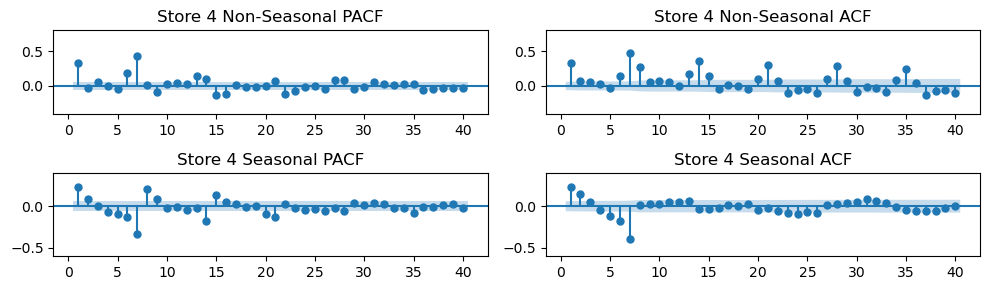

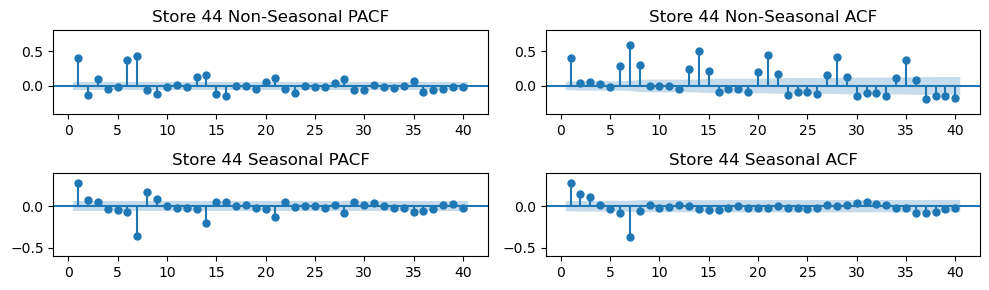

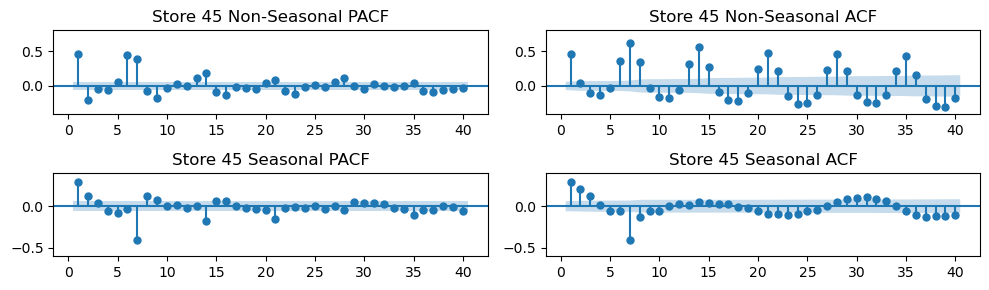

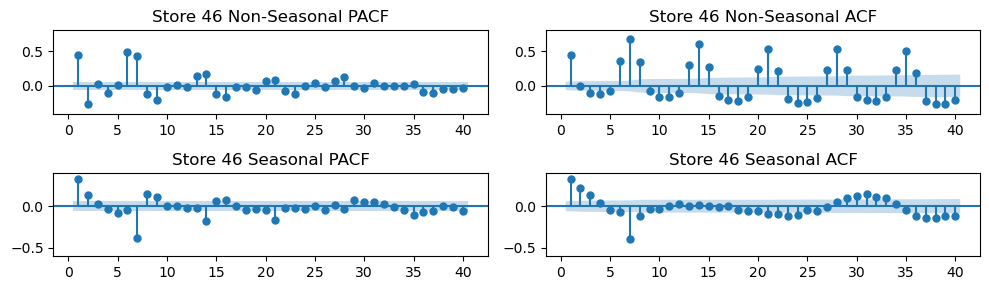

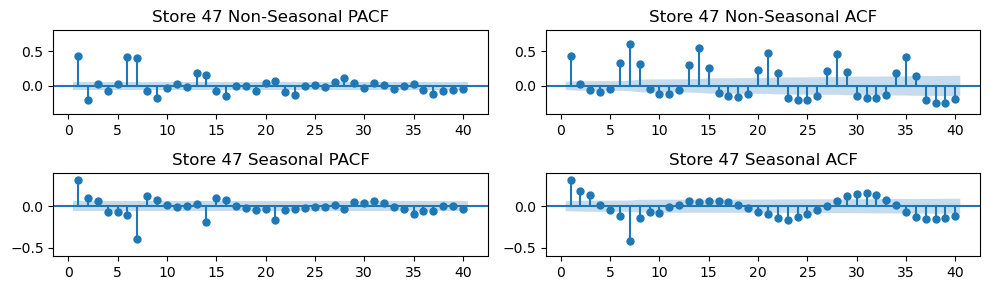

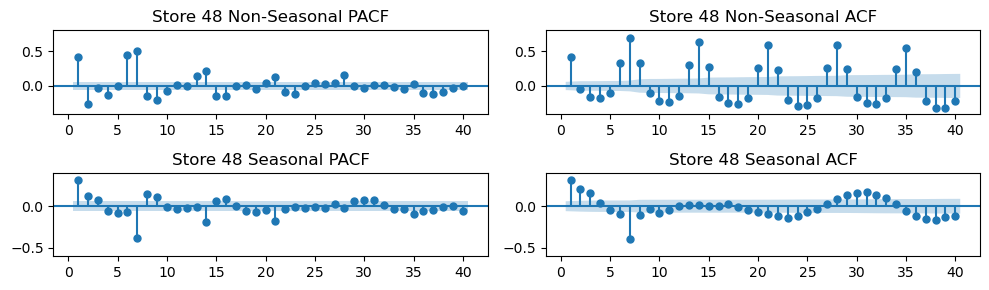

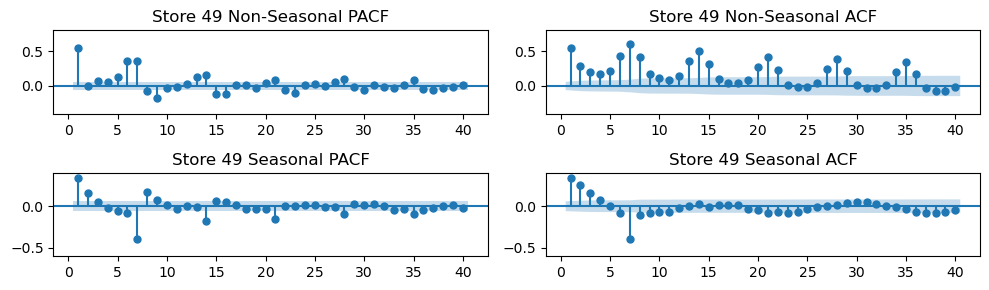

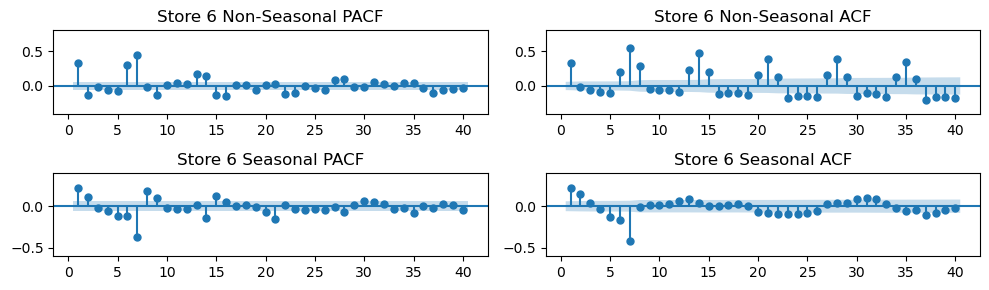

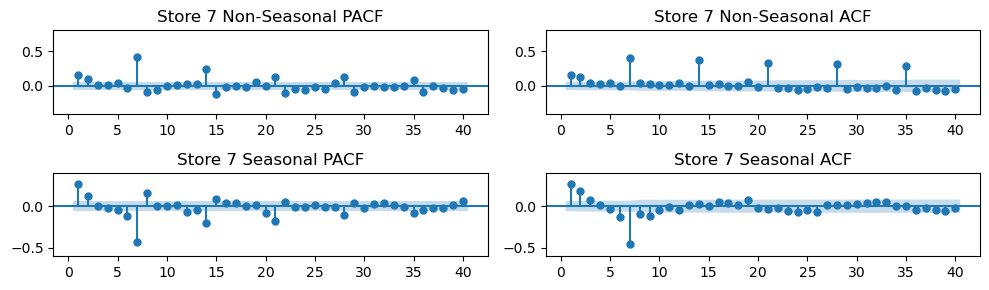

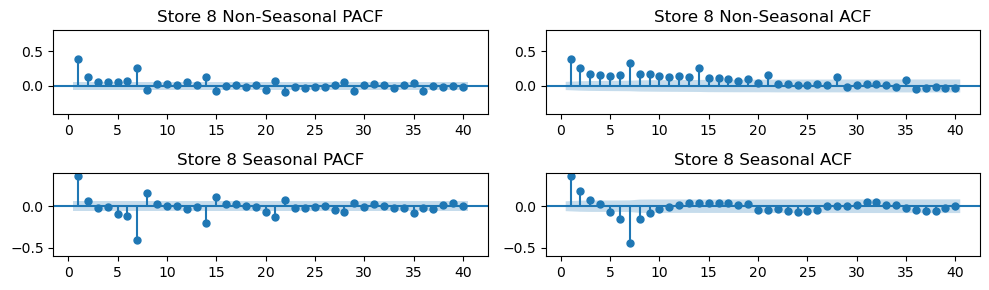

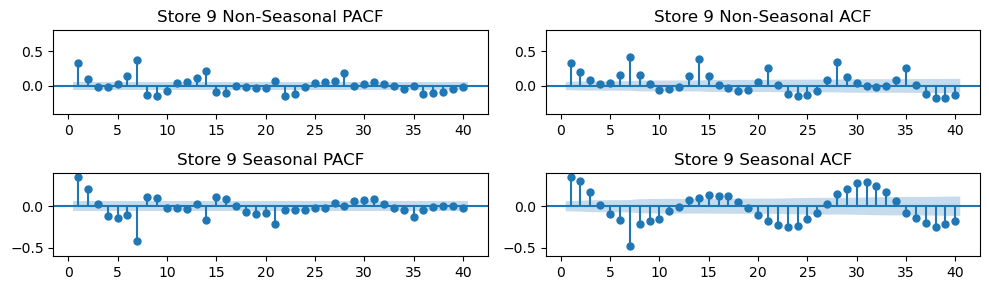

In [261]:
# Loop through each store to decide pq, PQ values
for s in stores:
    plt.figure(figsize=(10, 3))  # Adjust figure size

    # Check if the store needs differencing
    if s in [17, 20]:
        # Non-seasonal ACF and PACF plots after 1st order differencing
        data_to_plot = df_train.loc[df_train['store_nbr'] == s, "store_trans_filled"].diff(1).dropna()
        title_suffix = " (Differenced)"
    else:
        # Non-seasonal ACF and PACF plots without differencing
        data_to_plot = df_train.loc[df_train['store_nbr'] == s, "store_trans_filled"]
        title_suffix = ""

    # Non-seasonal PACF
    plt.subplot(2, 2, 1)
    plot_pacf(data_to_plot, zero=False, lags=40, ax=plt.gca())
    plt.title(f"Store {s} Non-Seasonal PACF{title_suffix}")
    plt.ylim(-0.4, 0.8)
    
    # Non-seasonal ACF
    plt.subplot(2, 2, 2)
    plot_acf(data_to_plot, zero=False, lags=40, ax=plt.gca())
    plt.title(f"Store {s} Non-Seasonal ACF{title_suffix}")
    plt.ylim(-0.4, 0.8)

    # Seasonal differencing and ACF, PACF plots (7-day difference)
    seasonal_data = df_train.loc[df_train['store_nbr'] == s, "store_trans_filled"].diff(7).dropna()
    
    # Seasonal PACF
    plt.subplot(2, 2, 3)
    plot_pacf(seasonal_data, zero=False, lags=40, ax=plt.gca())
    plt.title(f"Store {s} Seasonal PACF")
    plt.ylim(-0.6, 0.4)
    
    # Seasonal ACF
    plt.subplot(2, 2, 4)
    plot_acf(seasonal_data, zero=False, lags=40, ax=plt.gca())
    plt.title(f"Store {s} Seasonal ACF")
    plt.ylim(-0.6, 0.4)

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

#### From the above plots, we can see except for seasonal effects, the autocorrelation usually become insignificant after lag3. Considering it takes too long to process with gridsearch. We are gonna manually do the model fitting.

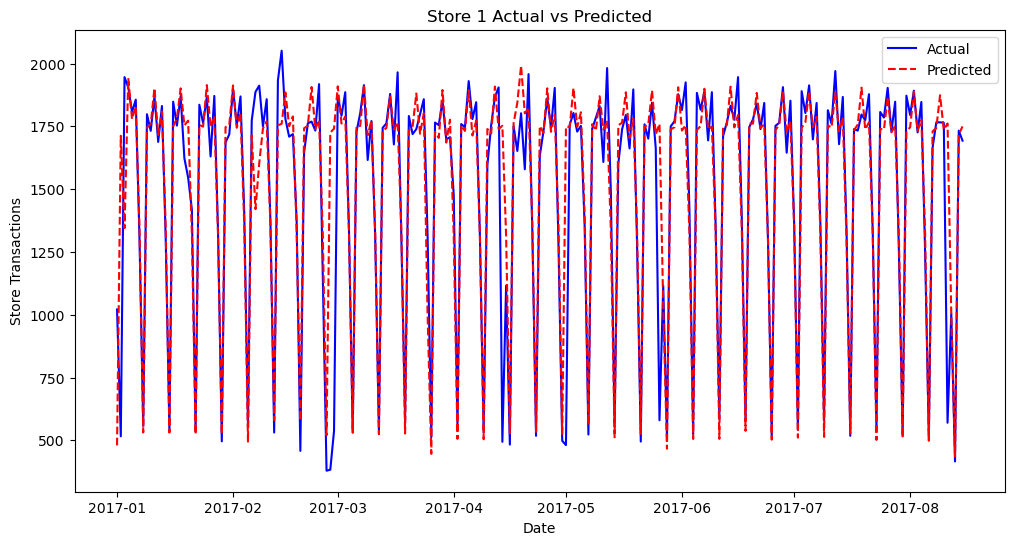

Mean Absolute Error: 103.62
mae/mean: 0.07


In [312]:
# Initialize the parameters
n=1
y_train = df_train.loc[df_train['store_nbr'] == n, "store_trans_filled"]
exog_train = df_train.loc[df_train['store_nbr'] == n, ["lag365", 'store_promo', 'dcoilwtico_interpolated', 'weekday', 'weekend']]
exog_test = df_test.loc[df_test['store_nbr'] == n, ["lag365", 'store_promo', 'dcoilwtico_interpolated','weekday', 'weekend']]
y_test = df_test.loc[df_test['store_nbr'] == n, "store_trans_filled"]

# Ensure indices are DatetimeIndex with daily frequency
y_train.index = pd.to_datetime(y_train.index).to_period('D').to_timestamp()
exog_train.index = pd.to_datetime(exog_train.index).to_period('D').to_timestamp()
y_test.index = pd.to_datetime(y_test.index).to_period('D').to_timestamp()
exog_test.index = pd.to_datetime(exog_test.index).to_period('D').to_timestamp()

d = 1 if n in[17,20] else 0
D=1
# Test with store 1 and see with less exogenous features if the result will be affected negatively
# Define the SARIMAX model
model = SARIMAX(
    y_train,                             # Endogenous variable
    exog=exog_train,                     # Exogenous variables for training
    order=(1, 0, 1),                     # (p, d, q)
    seasonal_order=(1, 1, 1, 7)          # (P, D, Q, s) where s is the seasonal period
)

# Fit the model
results = model.fit(disp=True,maxiter=1000)
# Predict the values for the specified period
predictions = results.predict(
    start='2017-01-01', 
    end='2017-08-15', 
    exog=exog_test
)

# Plot the real vs predicted values
plt.figure(figsize=(12, 6))
# Plot the actual data
plt.plot(y_test, label='Actual', color='blue', linestyle='-')
# Plot the predictions
plt.plot(predictions, label='Predicted', color='red', linestyle='--')
# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Store Transactions')
plt.title(f'Store {n} Actual vs Predicted')
plt.legend()
# Display the plot
plt.show()

# Evaluate the model
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error: {mae:.2f}')
print(f'mae/mean: {mae/y_test.mean():.2f}')

# Save the predicted result to the table
df.loc[(df['store_nbr'] == n) & (df.index.isin(predictions.index)), "store_trans_pred"] = predictions.values

In [313]:
# sanity check
df.loc[df['store_nbr'] == 1, :].tail()

store_nbr  store_promo    year  month   day  \
date                                                      
2014-01-02          1          0.0  2014.0    1.0   2.0   
2014-01-03          1          0.0  2014.0    1.0   3.0   
2014-01-04          1          0.0  2014.0    1.0   4.0   
2014-01-05          1          0.0  2014.0    1.0   5.0   
2014-01-06          1          0.0  2014.0    1.0   6.0   
...               ...          ...     ...    ...   ...   
2017-08-11          1        216.0  2017.0    8.0  11.0   
2017-08-12          1        103.0  2017.0    8.0  12.0   
2017-08-13          1         73.0  2017.0    8.0  13.0   
2017-08-14          1        120.0  2017.0    8.0  14.0   
2017-08-15          1        115.0  2017.0    8.0  15.0   

            dcoilwtico_interpolated  store_trans_filled  weekday  weekend  \
date                                                                        
2014-01-02                95.140000              1875.0      4.0      0.0   
2014-01-03                93.660000              1817.0      5.0      0.0   
2014-01-04                93.480000              1294.0      0.0      1.0   
2014-01-05                93.300000               489.0      0.0      1.0   
2014-01-06                93.120000              1754.0      1.0      0.0   
...                             ...                 ...      ...      ...   
2017-08-11                48.810000               570.0      5.0      0.0   
2017-08-12                48.403333              1004.0      0.0      1.0   
2017-08-13                47.996667               416.0      0.0      1.0   
2017-08-14                47.590000              1733.0      1.0      0.0   
2017-08-15                47.570000              1693.0      2.0      0.0   

            lag365  store_trans_pred  
date                                  
2014-01-02  2111.0               NaN  
2014-01-03  1833.0               NaN  
2014-01-04  1863.0               NaN  
2014-01-05  1509.0               NaN  
2014-01-06   520.0               NaN  
...            ...               ...  
2017-08-11  1697.0       1761.356212  
2017-08-12   515.0       1001.894409  
2017-08-13  1001.0        435.532391  
2017-08-14   423.0       1716.674664  
2017-08-15  1776.0       1749.779467  

[1322 rows x 11 columns]

C:\Users\erinb\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\erinb\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Best MAE: 57.68, Best MAE/MEAN: 0.07 Best (p, q, P, Q): (2, 3, 2, 2)


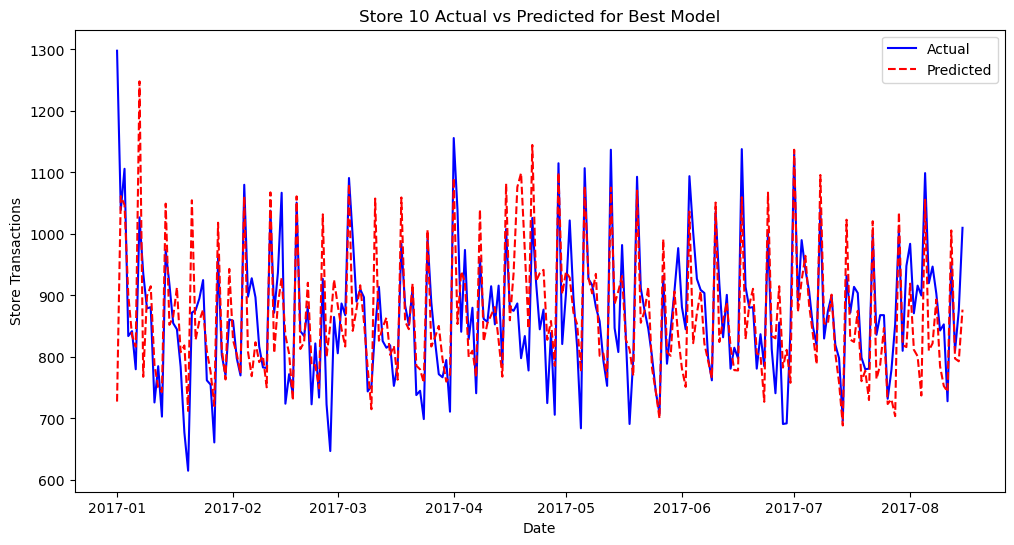

In [326]:
# Initialize parameters
n = 10
y_train = df_train.loc[df_train['store_nbr'] == n, "store_trans_filled"]
exog_train = df_train.loc[df_train['store_nbr'] == n, ["lag365", 'store_promo', 'dcoilwtico_interpolated', 'weekday', 'weekend']]
exog_test = df_test.loc[df_test['store_nbr'] == n, ["lag365", 'store_promo', 'dcoilwtico_interpolated', 'weekday', 'weekend']]
y_test = df_test.loc[df_test['store_nbr'] == n, "store_trans_filled"]

# Ensure indices are DatetimeIndex with daily frequency
y_train.index = pd.to_datetime(y_train.index).to_period('D').to_timestamp()
exog_train.index = pd.to_datetime(exog_train.index).to_period('D').to_timestamp()
y_test.index = pd.to_datetime(y_test.index).to_period('D').to_timestamp()
exog_test.index = pd.to_datetime(exog_test.index).to_period('D').to_timestamp()

d = 1 if n in [17, 20] else 0
D = 1

# Initialize best model parameters
best_model = None
best_mae = np.inf
best_predictions = None

# Define SARIMAX model with parameter grid
for p, q, P, Q in product([2], [3], [2], [2]):
    try:
        # Initialize and fit the SARIMAX model
        model = SARIMAX(
            y_train,
            exog=exog_train,
            order=(p, d, q),
            seasonal_order=(P, D, Q, 7)
        )
        
        results = model.fit(disp=False, maxiter=2000)
        
        # Predict values for the specified period
        predictions = results.predict(start='2017-01-01', end='2017-08-15', exog=exog_test)
        
        # Calculate Mean Absolute Error
        mae = mean_absolute_error(y_test, predictions)
        
        # Save the best model based on MAE
        if mae < best_mae:
            best_mae = mae
            best_model = model
            best_predictions = predictions
            best_pqPQ = (p, q, P, Q)  # Store the best parameters
        
    except Exception as e:
        print(f"Model with (p={p}, q={q}, P={P}, Q={Q}) failed: {e}")

# Print the best MAE and model parameters
if best_model:
    print(f'Best MAE: {best_mae:.2f}, Best MAE/MEAN: {best_mae/y_test.mean():.2f} Best (p, q, P, Q): {best_pqPQ}')
else:
    print("No valid models found.")

# Plot the real vs predicted values of the best model
if best_predictions is not None:
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='Actual', color='blue', linestyle='-')
    plt.plot(best_predictions, label='Predicted', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Store Transactions')
    plt.title(f'Store {n} Actual vs Predicted for Best Model')
    plt.legend()
    plt.show()
else:
    print("No predictions available to plot.")

# Save the best predicted result to the DataFrame
if best_predictions is not None:
    df.loc[(df['store_nbr'] == n) & (df.index.isin(best_predictions.index)), "store_trans_pred"] = best_predictions.values
else:
    print("No predictions available to save.")

In [327]:
# sanity check
df.loc[df['store_nbr'] == 10, :].tail()

store_nbr  store_promo    year  month   day  \
date                                                      
2017-08-11         10        174.0  2017.0    8.0  11.0   
2017-08-12         10        136.0  2017.0    8.0  12.0   
2017-08-13         10        158.0  2017.0    8.0  13.0   
2017-08-14         10        135.0  2017.0    8.0  14.0   
2017-08-15         10        191.0  2017.0    8.0  15.0   

            dcoilwtico_interpolated  store_trans_filled  weekday  weekend  \
date                                                                        
2017-08-11                48.810000               728.0      5.0      0.0   
2017-08-12                48.403333               953.0      0.0      1.0   
2017-08-13                47.996667               810.0      0.0      1.0   
2017-08-14                47.590000               875.0      1.0      0.0   
2017-08-15                47.570000              1010.0      2.0      0.0   

            lag365  store_trans_pred  
date                                  
2017-08-11   845.0        743.529715  
2017-08-12   723.0       1005.764598  
2017-08-13   991.0        797.442092  
2017-08-14   778.0        792.937806  
2017-08-15   864.0        876.964925

Best MAE: 116.67, Best MAE/MEAN: 0.08 Best (p, q, P, Q): (1, 1, 2, 2)


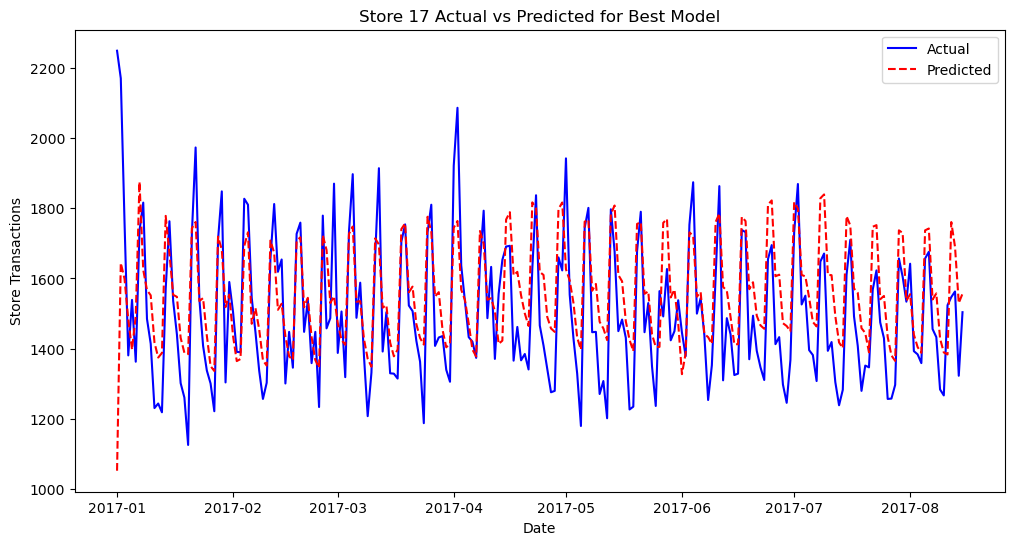

In [323]:
# Initialize parameters
n = 17
y_train = df_train.loc[df_train['store_nbr'] == n, "store_trans_filled"]
exog_train = df_train.loc[df_train['store_nbr'] == n, ["lag365", 'store_promo', 'dcoilwtico_interpolated', 'weekday', 'weekend']]
exog_test = df_test.loc[df_test['store_nbr'] == n, ["lag365", 'store_promo', 'dcoilwtico_interpolated', 'weekday', 'weekend']]
y_test = df_test.loc[df_test['store_nbr'] == n, "store_trans_filled"]

# Ensure indices are DatetimeIndex with daily frequency
y_train.index = pd.to_datetime(y_train.index).to_period('D').to_timestamp()
exog_train.index = pd.to_datetime(exog_train.index).to_period('D').to_timestamp()
y_test.index = pd.to_datetime(y_test.index).to_period('D').to_timestamp()
exog_test.index = pd.to_datetime(exog_test.index).to_period('D').to_timestamp()

d = 1 if n in [17, 20] else 0
D = 1

# Initialize best model parameters
best_model = None
best_mae = np.inf
best_predictions = None

# Define SARIMAX model with parameter grid
for p, q, P, Q in product([1, 2], [1,2], [1,2], [1,2]):
    try:
        # Initialize and fit the SARIMAX model
        model = SARIMAX(
            y_train,
            exog=exog_train,
            order=(p, d, q),
            seasonal_order=(P, D, Q, 7)
        )
        
        results = model.fit(disp=False, maxiter=2000)
        
        # Predict values for the specified period
        predictions = results.predict(start='2017-01-01', end='2017-08-15', exog=exog_test)
        
        # Calculate Mean Absolute Error
        mae = mean_absolute_error(y_test, predictions)
        
        # Save the best model based on MAE
        if mae < best_mae:
            best_mae = mae
            best_model = model
            best_predictions = predictions
            best_pqPQ = (p, q, P, Q)  # Store the best parameters
        
    except Exception as e:
        print(f"Model with (p={p}, q={q}, P={P}, Q={Q}) failed: {e}")

# Print the best MAE and model parameters
if best_model:
    print(f'Best MAE: {best_mae:.2f}, Best MAE/MEAN: {best_mae/y_test.mean():.2f} Best (p, q, P, Q): {best_pqPQ}')
else:
    print("No valid models found.")

# Plot the real vs predicted values of the best model
if best_predictions is not None:
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='Actual', color='blue', linestyle='-')
    plt.plot(best_predictions, label='Predicted', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Store Transactions')
    plt.title(f'Store {n} Actual vs Predicted for Best Model')
    plt.legend()
    plt.show()
else:
    print("No predictions available to plot.")

# Save the best predicted result to the DataFrame
if best_predictions is not None:
    df.loc[(df['store_nbr'] == n) & (df.index.isin(best_predictions.index)), "store_trans_pred"] = best_predictions.values
else:
    print("No predictions available to save.")

In [325]:
# sanity check
df.loc[df['store_nbr'] == 17 , :].tail()

store_nbr  store_promo    year  month   day  \
date                                                      
2017-08-11         17        232.0  2017.0    8.0  11.0   
2017-08-12         17        184.0  2017.0    8.0  12.0   
2017-08-13         17        196.0  2017.0    8.0  13.0   
2017-08-14         17        170.0  2017.0    8.0  14.0   
2017-08-15         17        268.0  2017.0    8.0  15.0   

            dcoilwtico_interpolated  store_trans_filled  weekday  weekend  \
date                                                                        
2017-08-11                48.810000              1524.0      5.0      0.0   
2017-08-12                48.403333              1547.0      0.0      1.0   
2017-08-13                47.996667              1563.0      0.0      1.0   
2017-08-14                47.590000              1323.0      1.0      0.0   
2017-08-15                47.570000              1504.0      2.0      0.0   

            lag365  store_trans_pred  
date                                  
2017-08-11  1328.0       1383.703243  
2017-08-12  1445.0       1760.626787  
2017-08-13  1468.0       1689.838632  
2017-08-14  1472.0       1529.954441  
2017-08-15  1500.0       1556.793012

Best MAE: 131.99, Best MAE/MEAN: 0.07 Best (p, q, P, Q): (1, 2, 1, 2)


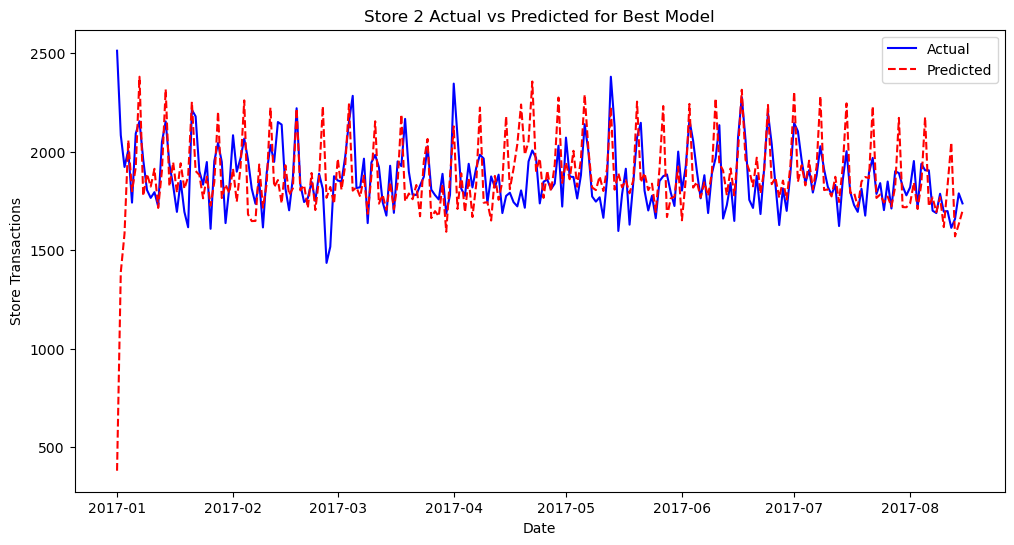

In [328]:
# Initialize parameters
n = 2
y_train = df_train.loc[df_train['store_nbr'] == n, "store_trans_filled"]
exog_train = df_train.loc[df_train['store_nbr'] == n, ["lag365", 'store_promo', 'dcoilwtico_interpolated', 'weekday', 'weekend']]
exog_test = df_test.loc[df_test['store_nbr'] == n, ["lag365", 'store_promo', 'dcoilwtico_interpolated', 'weekday', 'weekend']]
y_test = df_test.loc[df_test['store_nbr'] == n, "store_trans_filled"]

# Ensure indices are DatetimeIndex with daily frequency
y_train.index = pd.to_datetime(y_train.index).to_period('D').to_timestamp()
exog_train.index = pd.to_datetime(exog_train.index).to_period('D').to_timestamp()
y_test.index = pd.to_datetime(y_test.index).to_period('D').to_timestamp()
exog_test.index = pd.to_datetime(exog_test.index).to_period('D').to_timestamp()

d = 1 if n in [17, 20] else 0
D = 1

# Initialize best model parameters
best_model = None
best_mae = np.inf
best_predictions = None

# Define SARIMAX model with parameter grid
for p, q, P, Q in product([1], [1,2], [1], [1,2]):
    try:
        # Initialize and fit the SARIMAX model
        model = SARIMAX(
            y_train,
            exog=exog_train,
            order=(p, d, q),
            seasonal_order=(P, D, Q, 7)
        )
        
        results = model.fit(disp=False, maxiter=2000)
        
        # Predict values for the specified period
        predictions = results.predict(start='2017-01-01', end='2017-08-15', exog=exog_test)
        
        # Calculate Mean Absolute Error
        mae = mean_absolute_error(y_test, predictions)
        
        # Save the best model based on MAE
        if mae < best_mae:
            best_mae = mae
            best_model = model
            best_predictions = predictions
            best_pqPQ = (p, q, P, Q)  # Store the best parameters
        
    except Exception as e:
        print(f"Model with (p={p}, q={q}, P={P}, Q={Q}) failed: {e}")

# Print the best MAE and model parameters
if best_model:
    print(f'Best MAE: {best_mae:.2f}, Best MAE/MEAN: {best_mae/y_test.mean():.2f} Best (p, q, P, Q): {best_pqPQ}')
else:
    print("No valid models found.")

# Plot the real vs predicted values of the best model
if best_predictions is not None:
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='Actual', color='blue', linestyle='-')
    plt.plot(best_predictions, label='Predicted', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Store Transactions')
    plt.title(f'Store {n} Actual vs Predicted for Best Model')
    plt.legend()
    plt.show()
else:
    print("No predictions available to plot.")

# Save the best predicted result to the DataFrame
if best_predictions is not None:
    df.loc[(df['store_nbr'] == n) & (df.index.isin(best_predictions.index)), "store_trans_pred"] = best_predictions.values
else:
    print("No predictions available to save.")

In [329]:
# sanity check
df.loc[df['store_nbr'] == 2 , :].tail()

store_nbr  store_promo    year  month   day  \
date                                                      
2017-08-11          2        296.0  2017.0    8.0  11.0   
2017-08-12          2        123.0  2017.0    8.0  12.0   
2017-08-13          2        129.0  2017.0    8.0  13.0   
2017-08-14          2        126.0  2017.0    8.0  14.0   
2017-08-15          2        118.0  2017.0    8.0  15.0   

            dcoilwtico_interpolated  store_trans_filled  weekday  weekend  \
date                                                                        
2017-08-11                48.810000              1698.0      5.0      0.0   
2017-08-12                48.403333              1613.0      0.0      1.0   
2017-08-13                47.996667              1658.0      0.0      1.0   
2017-08-14                47.590000              1788.0      1.0      0.0   
2017-08-15                47.570000              1737.0      2.0      0.0   

            lag365  store_trans_pred  
date                                  
2017-08-11  1736.0       1826.235360  
2017-08-12  1630.0       2045.894603  
2017-08-13  1674.0       1569.766034  
2017-08-14  1600.0       1631.587282  
2017-08-15  1789.0       1698.848886

C:\Users\erinb\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\erinb\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\erinb\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\erinb\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Best MAE: 176.60, Best MAE/MEAN: 0.11 Best (p, q, P, Q): (1, 1, 2, 2)


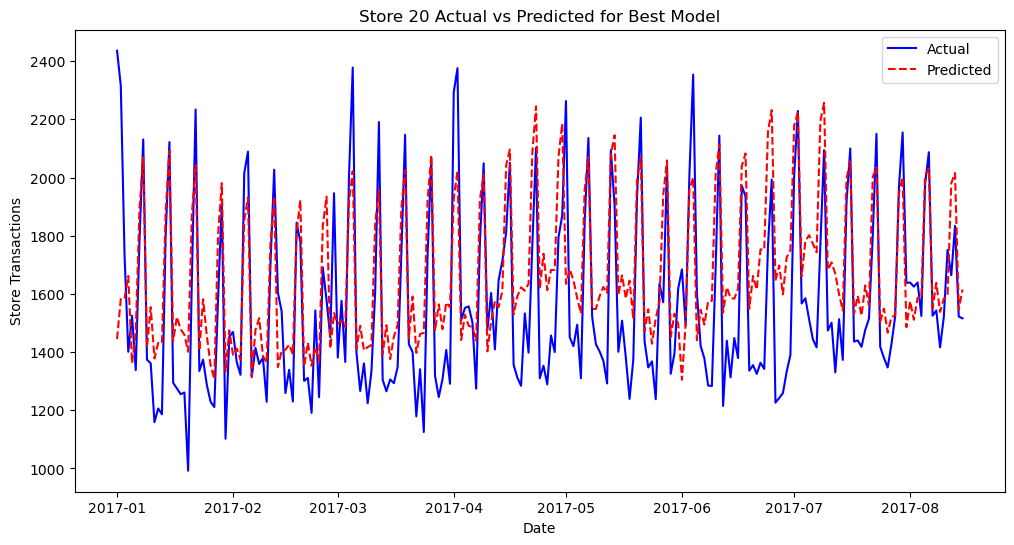

In [330]:
# Initialize parameters
n = 20
y_train = df_train.loc[df_train['store_nbr'] == n, "store_trans_filled"]
exog_train = df_train.loc[df_train['store_nbr'] == n, ["lag365", 'store_promo', 'dcoilwtico_interpolated', 'weekday', 'weekend']]
exog_test = df_test.loc[df_test['store_nbr'] == n, ["lag365", 'store_promo', 'dcoilwtico_interpolated', 'weekday', 'weekend']]
y_test = df_test.loc[df_test['store_nbr'] == n, "store_trans_filled"]

# Ensure indices are DatetimeIndex with daily frequency
y_train.index = pd.to_datetime(y_train.index).to_period('D').to_timestamp()
exog_train.index = pd.to_datetime(exog_train.index).to_period('D').to_timestamp()
y_test.index = pd.to_datetime(y_test.index).to_period('D').to_timestamp()
exog_test.index = pd.to_datetime(exog_test.index).to_period('D').to_timestamp()

d = 1 if n in [17, 20] else 0
D = 1

# Initialize best model parameters
best_model = None
best_mae = np.inf
best_predictions = None

# Define SARIMAX model with parameter grid
for p, q, P, Q in product([1,2,5,6], [1], [1,2], [1,2]):
    try:
        # Initialize and fit the SARIMAX model
        model = SARIMAX(
            y_train,
            exog=exog_train,
            order=(p, d, q),
            seasonal_order=(P, D, Q, 7)
        )
        
        results = model.fit(disp=False, maxiter=2000)
        
        # Predict values for the specified period
        predictions = results.predict(start='2017-01-01', end='2017-08-15', exog=exog_test)
        
        # Calculate Mean Absolute Error
        mae = mean_absolute_error(y_test, predictions)
        
        # Save the best model based on MAE
        if mae < best_mae:
            best_mae = mae
            best_model = model
            best_predictions = predictions
            best_pqPQ = (p, q, P, Q)  # Store the best parameters
        
    except Exception as e:
        print(f"Model with (p={p}, q={q}, P={P}, Q={Q}) failed: {e}")

# Print the best MAE and model parameters
if best_model:
    print(f'Best MAE: {best_mae:.2f}, Best MAE/MEAN: {best_mae/y_test.mean():.2f} Best (p, q, P, Q): {best_pqPQ}')
else:
    print("No valid models found.")

# Plot the real vs predicted values of the best model
if best_predictions is not None:
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='Actual', color='blue', linestyle='-')
    plt.plot(best_predictions, label='Predicted', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Store Transactions')
    plt.title(f'Store {n} Actual vs Predicted for Best Model')
    plt.legend()
    plt.show()
else:
    print("No predictions available to plot.")

# Save the best predicted result to the DataFrame
if best_predictions is not None:
    df.loc[(df['store_nbr'] == n) & (df.index.isin(best_predictions.index)), "store_trans_pred"] = best_predictions.values
else:
    print("No predictions available to save.")

In [331]:
# sanity check
df.loc[df['store_nbr'] == 20 , :].tail()

store_nbr  store_promo    year  month   day  \
date                                                      
2017-08-11         20        279.0  2017.0    8.0  11.0   
2017-08-12         20        213.0  2017.0    8.0  12.0   
2017-08-13         20        264.0  2017.0    8.0  13.0   
2017-08-14         20        206.0  2017.0    8.0  14.0   
2017-08-15         20        306.0  2017.0    8.0  15.0   

            dcoilwtico_interpolated  store_trans_filled  weekday  weekend  \
date                                                                        
2017-08-11                48.810000              1751.0      5.0      0.0   
2017-08-12                48.403333              1664.0      0.0      1.0   
2017-08-13                47.996667              1834.0      0.0      1.0   
2017-08-14                47.590000              1522.0      1.0      0.0   
2017-08-15                47.570000              1516.0      2.0      0.0   

            lag365  store_trans_pred  
date                                  
2017-08-11  1270.0       1593.086116  
2017-08-12  1508.0       1980.612609  
2017-08-13  1487.0       2015.418162  
2017-08-14  1586.0       1546.427566  
2017-08-15  1426.0       1615.073286

Best MAE: 218.56, Best MAE/MEAN: 0.07 Best (p, q, P, Q): (1, 1, 1, 2)


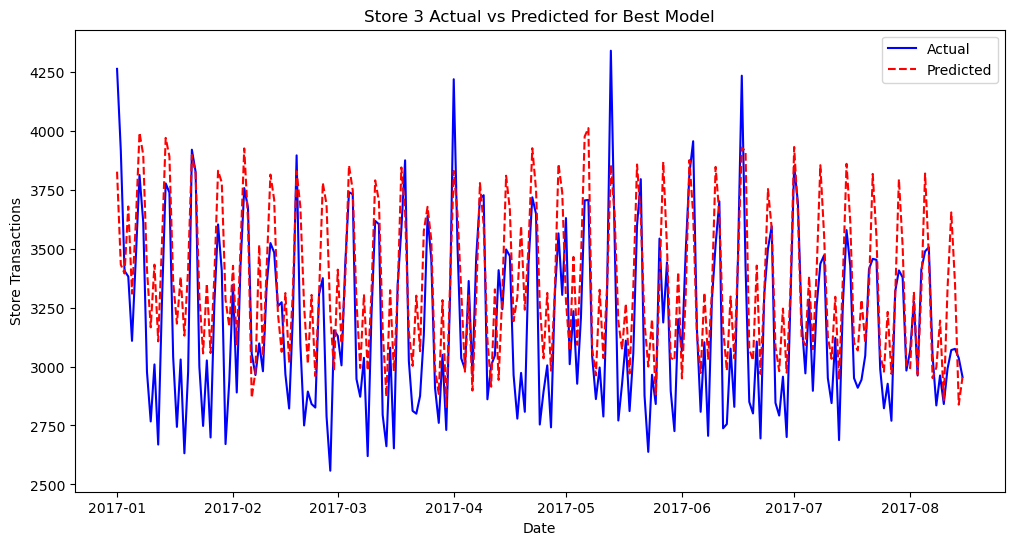

In [335]:
# Initialize parameters
n = 3
y_train = df_train.loc[df_train['store_nbr'] == n, "store_trans_filled"]
exog_train = df_train.loc[df_train['store_nbr'] == n, ["lag365", 'store_promo', 'dcoilwtico_interpolated', 'weekday', 'weekend']]
exog_test = df_test.loc[df_test['store_nbr'] == n, ["lag365", 'store_promo', 'dcoilwtico_interpolated', 'weekday', 'weekend']]
y_test = df_test.loc[df_test['store_nbr'] == n, "store_trans_filled"]

# Ensure indices are DatetimeIndex with daily frequency
y_train.index = pd.to_datetime(y_train.index).to_period('D').to_timestamp()
exog_train.index = pd.to_datetime(exog_train.index).to_period('D').to_timestamp()
y_test.index = pd.to_datetime(y_test.index).to_period('D').to_timestamp()
exog_test.index = pd.to_datetime(exog_test.index).to_period('D').to_timestamp()

d = 1 if n in [17, 20] else 0
D = 1

# Initialize best model parameters
best_model = None
best_mae = np.inf
best_predictions = None

# Define SARIMAX model with parameter grid
for p, q, P, Q in product([1], [1], [1], [2]):
    try:
        # Initialize and fit the SARIMAX model
        model = SARIMAX(
            y_train,
            exog=exog_train,
            order=(p, d, q),
            seasonal_order=(P, D, Q, 7)
        )
        
        results = model.fit(disp=False, maxiter=2000)
        
        # Predict values for the specified period
        predictions = results.predict(start='2017-01-01', end='2017-08-15', exog=exog_test)
        
        # Calculate Mean Absolute Error
        mae = mean_absolute_error(y_test, predictions)
        
        # Save the best model based on MAE
        if mae < best_mae:
            best_mae = mae
            best_model = model
            best_predictions = predictions
            best_pqPQ = (p, q, P, Q)  # Store the best parameters
        
    except Exception as e:
        print(f"Model with (p={p}, q={q}, P={P}, Q={Q}) failed: {e}")

# Print the best MAE and model parameters
if best_model:
    print(f'Best MAE: {best_mae:.2f}, Best MAE/MEAN: {best_mae/y_test.mean():.2f} Best (p, q, P, Q): {best_pqPQ}')
else:
    print("No valid models found.")

# Plot the real vs predicted values of the best model
if best_predictions is not None:
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='Actual', color='blue', linestyle='-')
    plt.plot(best_predictions, label='Predicted', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Store Transactions')
    plt.title(f'Store {n} Actual vs Predicted for Best Model')
    plt.legend()
    plt.show()
else:
    print("No predictions available to plot.")

# Save the best predicted result to the DataFrame
if best_predictions is not None:
    df.loc[(df['store_nbr'] == n) & (df.index.isin(best_predictions.index)), "store_trans_pred"] = best_predictions.values
else:
    print("No predictions available to save.")

In [336]:
# sanity check
df.loc[df['store_nbr'] == 3 , :].tail()

store_nbr  store_promo    year  month   day  \
date                                                      
2017-08-11          3        340.0  2017.0    8.0  11.0   
2017-08-12          3        148.0  2017.0    8.0  12.0   
2017-08-13          3        154.0  2017.0    8.0  13.0   
2017-08-14          3        143.0  2017.0    8.0  14.0   
2017-08-15          3        143.0  2017.0    8.0  15.0   

            dcoilwtico_interpolated  store_trans_filled  weekday  weekend  \
date                                                                        
2017-08-11                48.810000              2991.0      5.0      0.0   
2017-08-12                48.403333              3070.0      0.0      1.0   
2017-08-13                47.996667              3075.0      0.0      1.0   
2017-08-14                47.590000              3036.0      1.0      0.0   
2017-08-15                47.570000              2956.0      2.0      0.0   

            lag365  store_trans_pred  
date                                  
2017-08-11  2851.0       3331.801147  
2017-08-12  2956.0       3653.998297  
2017-08-13  3030.0       3350.665618  
2017-08-14  2896.0       2838.385382  
2017-08-15  2938.0       2955.379098

C:\Users\erinb\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\erinb\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\erinb\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\erinb\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\erinb\anaconda3\Lib\s

Best MAE: 97.08, Best MAE/MEAN: 0.07 Best (p, q, P, Q): (2, 2, 1, 2)


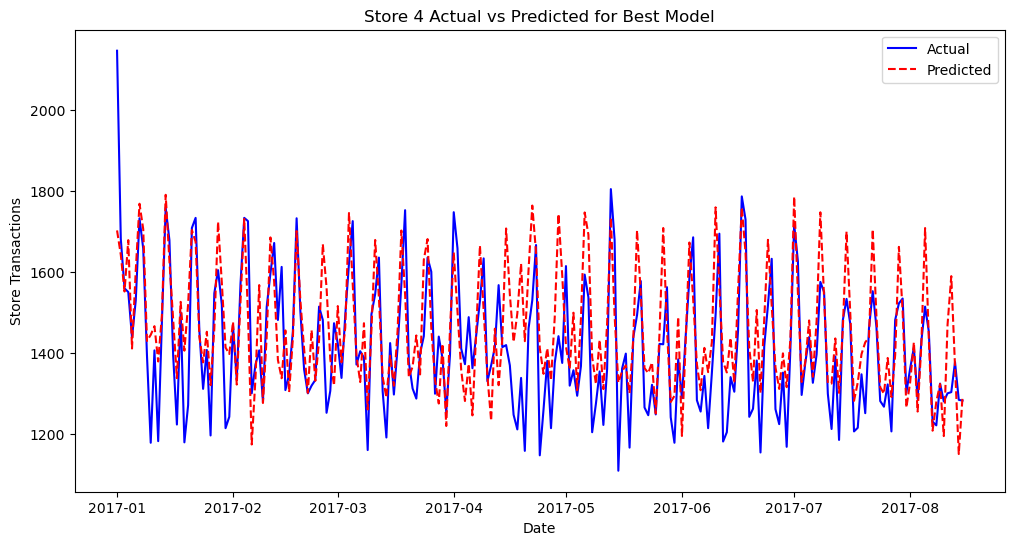

In [337]:
# Initialize parameters
n = 4
y_train = df_train.loc[df_train['store_nbr'] == n, "store_trans_filled"]
exog_train = df_train.loc[df_train['store_nbr'] == n, ["lag365", 'store_promo', 'dcoilwtico_interpolated', 'weekday', 'weekend']]
exog_test = df_test.loc[df_test['store_nbr'] == n, ["lag365", 'store_promo', 'dcoilwtico_interpolated', 'weekday', 'weekend']]
y_test = df_test.loc[df_test['store_nbr'] == n, "store_trans_filled"]

# Ensure indices are DatetimeIndex with daily frequency
y_train.index = pd.to_datetime(y_train.index).to_period('D').to_timestamp()
exog_train.index = pd.to_datetime(exog_train.index).to_period('D').to_timestamp()
y_test.index = pd.to_datetime(y_test.index).to_period('D').to_timestamp()
exog_test.index = pd.to_datetime(exog_test.index).to_period('D').to_timestamp()

d = 1 if n in [17, 20] else 0
D = 1

# Initialize best model parameters
best_model = None
best_mae = np.inf
best_predictions = None

# Define SARIMAX model with parameter grid
for p, q, P, Q in product([1,2], [1,2], [1,2], [1,2]):
    try:
        # Initialize and fit the SARIMAX model
        model = SARIMAX(
            y_train,
            exog=exog_train,
            order=(p, d, q),
            seasonal_order=(P, D, Q, 7)
        )
        
        results = model.fit(disp=False, maxiter=2000)
        
        # Predict values for the specified period
        predictions = results.predict(start='2017-01-01', end='2017-08-15', exog=exog_test)
        
        # Calculate Mean Absolute Error
        mae = mean_absolute_error(y_test, predictions)
        
        # Save the best model based on MAE
        if mae < best_mae:
            best_mae = mae
            best_model = model
            best_predictions = predictions
            best_pqPQ = (p, q, P, Q)  # Store the best parameters
        
    except Exception as e:
        print(f"Model with (p={p}, q={q}, P={P}, Q={Q}) failed: {e}")

# Print the best MAE and model parameters
if best_model:
    print(f'Best MAE: {best_mae:.2f}, Best MAE/MEAN: {best_mae/y_test.mean():.2f} Best (p, q, P, Q): {best_pqPQ}')
else:
    print("No valid models found.")

# Plot the real vs predicted values of the best model
if best_predictions is not None:
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='Actual', color='blue', linestyle='-')
    plt.plot(best_predictions, label='Predicted', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Store Transactions')
    plt.title(f'Store {n} Actual vs Predicted for Best Model')
    plt.legend()
    plt.show()
else:
    print("No predictions available to plot.")

# Save the best predicted result to the DataFrame
if best_predictions is not None:
    df.loc[(df['store_nbr'] == n) & (df.index.isin(best_predictions.index)), "store_trans_pred"] = best_predictions.values
else:
    print("No predictions available to save.")

In [338]:
# sanity check
df.loc[df['store_nbr'] == 4 , :].tail()

store_nbr  store_promo    year  month   day  \
date                                                      
2017-08-11          4        302.0  2017.0    8.0  11.0   
2017-08-12          4        124.0  2017.0    8.0  12.0   
2017-08-13          4        127.0  2017.0    8.0  13.0   
2017-08-14          4        121.0  2017.0    8.0  14.0   
2017-08-15          4        119.0  2017.0    8.0  15.0   

            dcoilwtico_interpolated  store_trans_filled  weekday  weekend  \
date                                                                        
2017-08-11                48.810000              1301.0      5.0      0.0   
2017-08-12                48.403333              1304.0      0.0      1.0   
2017-08-13                47.996667              1378.0      0.0      1.0   
2017-08-14                47.590000              1285.0      1.0      0.0   
2017-08-15                47.570000              1283.0      2.0      0.0   

            lag365  store_trans_pred  
date                                  
2017-08-11  1392.0       1470.198674  
2017-08-12  1288.0       1590.200199  
2017-08-13  1352.0       1367.063441  
2017-08-14  1283.0       1151.179394  
2017-08-15  1348.0       1291.232146

Best MAE: 278.85, Best MAE/MEAN: 0.06 Best (p, q, P, Q): (1, 1, 1, 1)


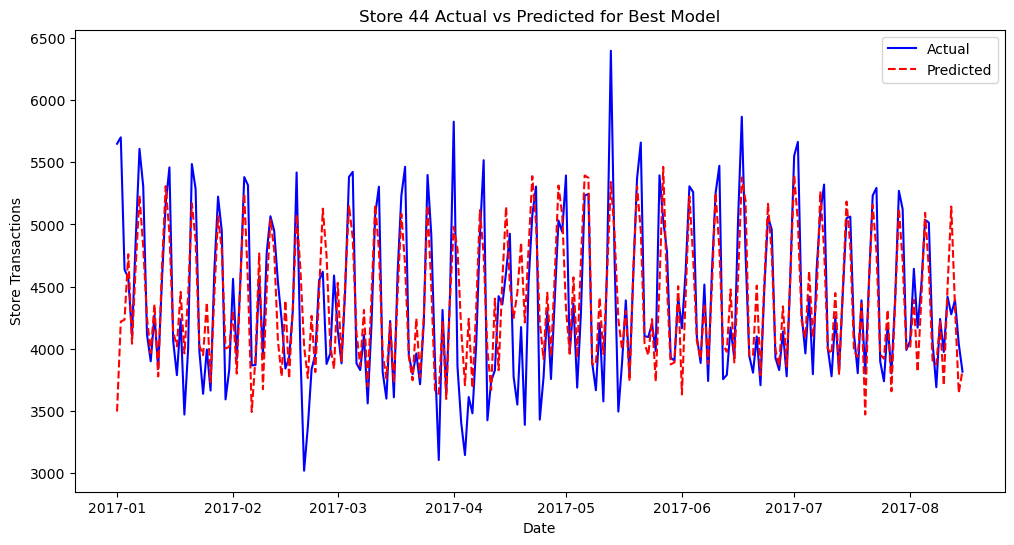

In [339]:
# Initialize parameters
n = 44
y_train = df_train.loc[df_train['store_nbr'] == n, "store_trans_filled"]
exog_train = df_train.loc[df_train['store_nbr'] == n, ["lag365", 'store_promo', 'dcoilwtico_interpolated', 'weekday', 'weekend']]
exog_test = df_test.loc[df_test['store_nbr'] == n, ["lag365", 'store_promo', 'dcoilwtico_interpolated', 'weekday', 'weekend']]
y_test = df_test.loc[df_test['store_nbr'] == n, "store_trans_filled"]

# Ensure indices are DatetimeIndex with daily frequency
y_train.index = pd.to_datetime(y_train.index).to_period('D').to_timestamp()
exog_train.index = pd.to_datetime(exog_train.index).to_period('D').to_timestamp()
y_test.index = pd.to_datetime(y_test.index).to_period('D').to_timestamp()
exog_test.index = pd.to_datetime(exog_test.index).to_period('D').to_timestamp()

d = 1 if n in [17, 20] else 0
D = 1

# Initialize best model parameters
best_model = None
best_mae = np.inf
best_predictions = None

# Define SARIMAX model with parameter grid
for p, q, P, Q in product([1], [1], [1], [1,2,3]):
    try:
        # Initialize and fit the SARIMAX model
        model = SARIMAX(
            y_train,
            exog=exog_train,
            order=(p, d, q),
            seasonal_order=(P, D, Q, 7)
        )
        
        results = model.fit(disp=False, maxiter=2000)
        
        # Predict values for the specified period
        predictions = results.predict(start='2017-01-01', end='2017-08-15', exog=exog_test)
        
        # Calculate Mean Absolute Error
        mae = mean_absolute_error(y_test, predictions)
        
        # Save the best model based on MAE
        if mae < best_mae:
            best_mae = mae
            best_model = model
            best_predictions = predictions
            best_pqPQ = (p, q, P, Q)  # Store the best parameters
        
    except Exception as e:
        print(f"Model with (p={p}, q={q}, P={P}, Q={Q}) failed: {e}")

# Print the best MAE and model parameters
if best_model:
    print(f'Best MAE: {best_mae:.2f}, Best MAE/MEAN: {best_mae/y_test.mean():.2f} Best (p, q, P, Q): {best_pqPQ}')
else:
    print("No valid models found.")

# Plot the real vs predicted values of the best model
if best_predictions is not None:
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='Actual', color='blue', linestyle='-')
    plt.plot(best_predictions, label='Predicted', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Store Transactions')
    plt.title(f'Store {n} Actual vs Predicted for Best Model')
    plt.legend()
    plt.show()
else:
    print("No predictions available to plot.")

# Save the best predicted result to the DataFrame
if best_predictions is not None:
    df.loc[(df['store_nbr'] == n) & (df.index.isin(best_predictions.index)), "store_trans_pred"] = best_predictions.values
else:
    print("No predictions available to save.")

In [340]:
# sanity check
df.loc[df['store_nbr'] == 44 , :].tail()

store_nbr  store_promo    year  month   day  \
date                                                      
2017-08-11         44        389.0  2017.0    8.0  11.0   
2017-08-12         44        181.0  2017.0    8.0  12.0   
2017-08-13         44        185.0  2017.0    8.0  13.0   
2017-08-14         44        179.0  2017.0    8.0  14.0   
2017-08-15         44        168.0  2017.0    8.0  15.0   

            dcoilwtico_interpolated  store_trans_filled  weekday  weekend  \
date                                                                        
2017-08-11                48.810000              4418.0      5.0      0.0   
2017-08-12                48.403333              4277.0      0.0      1.0   
2017-08-13                47.996667              4392.0      0.0      1.0   
2017-08-14                47.590000              4039.0      1.0      0.0   
2017-08-15                47.570000              3815.0      2.0      0.0   

            lag365  store_trans_pred  
date                                  
2017-08-11  3751.0       4492.977893  
2017-08-12  4340.0       5143.684687  
2017-08-13  4000.0       4332.098852  
2017-08-14  4044.0       3645.169183  
2017-08-15  3857.0       3825.480944

Model with (p=2, q=1, P=1, Q=3) failed: LU decomposition error.
Best MAE: 237.23, Best MAE/MEAN: 0.06 Best (p, q, P, Q): (2, 1, 1, 1)


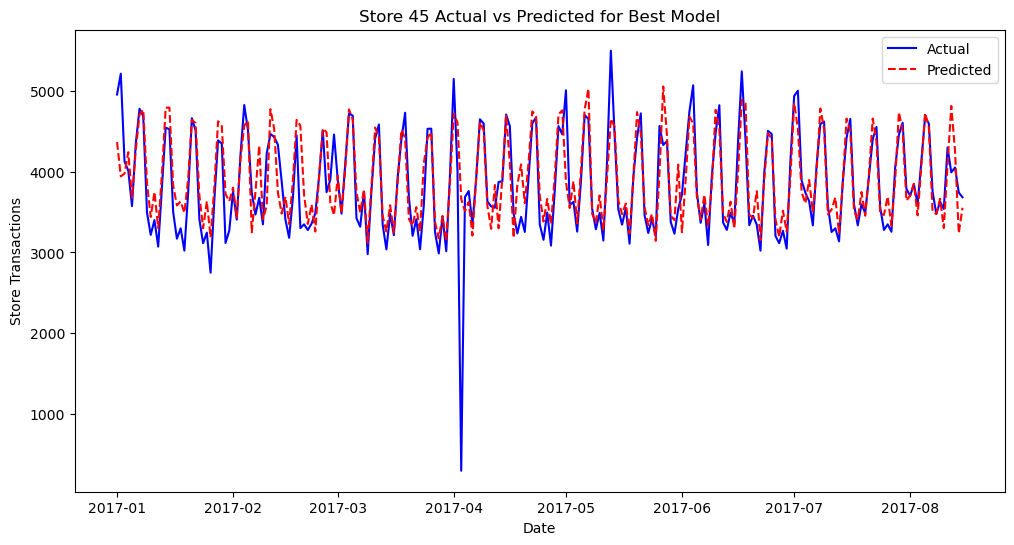

In [341]:
# Initialize parameters
n = 45
y_train = df_train.loc[df_train['store_nbr'] == n, "store_trans_filled"]
exog_train = df_train.loc[df_train['store_nbr'] == n, ["lag365", 'store_promo', 'dcoilwtico_interpolated', 'weekday', 'weekend']]
exog_test = df_test.loc[df_test['store_nbr'] == n, ["lag365", 'store_promo', 'dcoilwtico_interpolated', 'weekday', 'weekend']]
y_test = df_test.loc[df_test['store_nbr'] == n, "store_trans_filled"]

# Ensure indices are DatetimeIndex with daily frequency
y_train.index = pd.to_datetime(y_train.index).to_period('D').to_timestamp()
exog_train.index = pd.to_datetime(exog_train.index).to_period('D').to_timestamp()
y_test.index = pd.to_datetime(y_test.index).to_period('D').to_timestamp()
exog_test.index = pd.to_datetime(exog_test.index).to_period('D').to_timestamp()

d = 1 if n in [17, 20] else 0
D = 1

# Initialize best model parameters
best_model = None
best_mae = np.inf
best_predictions = None

# Define SARIMAX model with parameter grid
for p, q, P, Q in product([1,2], [1], [1], [1,2,3]):
    try:
        # Initialize and fit the SARIMAX model
        model = SARIMAX(
            y_train,
            exog=exog_train,
            order=(p, d, q),
            seasonal_order=(P, D, Q, 7)
        )
        
        results = model.fit(disp=False, maxiter=2000)
        
        # Predict values for the specified period
        predictions = results.predict(start='2017-01-01', end='2017-08-15', exog=exog_test)
        
        # Calculate Mean Absolute Error
        mae = mean_absolute_error(y_test, predictions)
        
        # Save the best model based on MAE
        if mae < best_mae:
            best_mae = mae
            best_model = model
            best_predictions = predictions
            best_pqPQ = (p, q, P, Q)  # Store the best parameters
        
    except Exception as e:
        print(f"Model with (p={p}, q={q}, P={P}, Q={Q}) failed: {e}")

# Print the best MAE and model parameters
if best_model:
    print(f'Best MAE: {best_mae:.2f}, Best MAE/MEAN: {best_mae/y_test.mean():.2f} Best (p, q, P, Q): {best_pqPQ}')
else:
    print("No valid models found.")

# Plot the real vs predicted values of the best model
if best_predictions is not None:
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='Actual', color='blue', linestyle='-')
    plt.plot(best_predictions, label='Predicted', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Store Transactions')
    plt.title(f'Store {n} Actual vs Predicted for Best Model')
    plt.legend()
    plt.show()
else:
    print("No predictions available to plot.")

# Save the best predicted result to the DataFrame
if best_predictions is not None:
    df.loc[(df['store_nbr'] == n) & (df.index.isin(best_predictions.index)), "store_trans_pred"] = best_predictions.values
else:
    print("No predictions available to save.")

In [342]:
# sanity check
df.loc[df['store_nbr'] == 45 , :].tail()

store_nbr  store_promo    year  month   day  \
date                                                      
2017-08-11         45        381.0  2017.0    8.0  11.0   
2017-08-12         45        172.0  2017.0    8.0  12.0   
2017-08-13         45        178.0  2017.0    8.0  13.0   
2017-08-14         45        164.0  2017.0    8.0  14.0   
2017-08-15         45        172.0  2017.0    8.0  15.0   

            dcoilwtico_interpolated  store_trans_filled  weekday  weekend  \
date                                                                        
2017-08-11                48.810000              4302.0      5.0      0.0   
2017-08-12                48.403333              3994.0      0.0      1.0   
2017-08-13                47.996667              4054.0      0.0      1.0   
2017-08-14                47.590000              3743.0      1.0      0.0   
2017-08-15                47.570000              3685.0      2.0      0.0   

            lag365  store_trans_pred  
date                                  
2017-08-11  3284.0       4087.656047  
2017-08-12  3990.0       4818.129156  
2017-08-13  3871.0       4260.302025  
2017-08-14  3707.0       3238.324779  
2017-08-15  3625.0       3554.295407

Best MAE: 235.30, Best MAE/MEAN: 0.07 Best (p, q, P, Q): (2, 1, 2, 1)


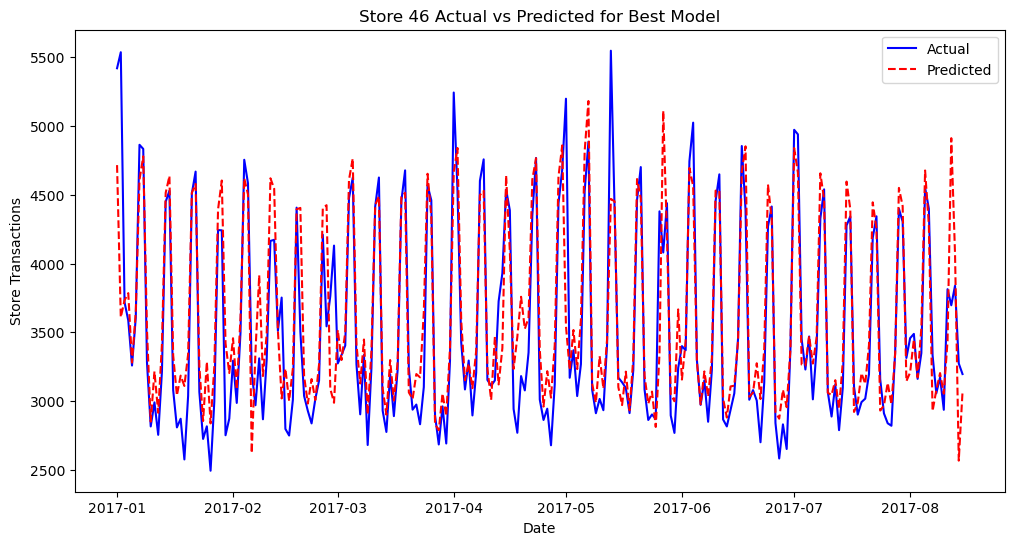

In [343]:
# Initialize parameters
n = 46
y_train = df_train.loc[df_train['store_nbr'] == n, "store_trans_filled"]
exog_train = df_train.loc[df_train['store_nbr'] == n, ["lag365", 'store_promo', 'dcoilwtico_interpolated', 'weekday', 'weekend']]
exog_test = df_test.loc[df_test['store_nbr'] == n, ["lag365", 'store_promo', 'dcoilwtico_interpolated', 'weekday', 'weekend']]
y_test = df_test.loc[df_test['store_nbr'] == n, "store_trans_filled"]

# Ensure indices are DatetimeIndex with daily frequency
y_train.index = pd.to_datetime(y_train.index).to_period('D').to_timestamp()
exog_train.index = pd.to_datetime(exog_train.index).to_period('D').to_timestamp()
y_test.index = pd.to_datetime(y_test.index).to_period('D').to_timestamp()
exog_test.index = pd.to_datetime(exog_test.index).to_period('D').to_timestamp()

d = 1 if n in [17, 20] else 0
D = 1

# Initialize best model parameters
best_model = None
best_mae = np.inf
best_predictions = None

# Define SARIMAX model with parameter grid
for p, q, P, Q in product([1,2], [1], [1,2], [1,2,3]):
    try:
        # Initialize and fit the SARIMAX model
        model = SARIMAX(
            y_train,
            exog=exog_train,
            order=(p, d, q),
            seasonal_order=(P, D, Q, 7)
        )
        
        results = model.fit(disp=False, maxiter=2000)
        
        # Predict values for the specified period
        predictions = results.predict(start='2017-01-01', end='2017-08-15', exog=exog_test)
        
        # Calculate Mean Absolute Error
        mae = mean_absolute_error(y_test, predictions)
        
        # Save the best model based on MAE
        if mae < best_mae:
            best_mae = mae
            best_model = model
            best_predictions = predictions
            best_pqPQ = (p, q, P, Q)  # Store the best parameters
        
    except Exception as e:
        print(f"Model with (p={p}, q={q}, P={P}, Q={Q}) failed: {e}")

# Print the best MAE and model parameters
if best_model:
    print(f'Best MAE: {best_mae:.2f}, Best MAE/MEAN: {best_mae/y_test.mean():.2f} Best (p, q, P, Q): {best_pqPQ}')
else:
    print("No valid models found.")

# Plot the real vs predicted values of the best model
if best_predictions is not None:
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='Actual', color='blue', linestyle='-')
    plt.plot(best_predictions, label='Predicted', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Store Transactions')
    plt.title(f'Store {n} Actual vs Predicted for Best Model')
    plt.legend()
    plt.show()
else:
    print("No predictions available to plot.")

# Save the best predicted result to the DataFrame
if best_predictions is not None:
    df.loc[(df['store_nbr'] == n) & (df.index.isin(best_predictions.index)), "store_trans_pred"] = best_predictions.values
else:
    print("No predictions available to save.")

In [344]:
# sanity check
df.loc[df['store_nbr'] == 46 , :].tail()

store_nbr  store_promo    year  month   day  \
date                                                      
2017-08-11         46        376.0  2017.0    8.0  11.0   
2017-08-12         46        183.0  2017.0    8.0  12.0   
2017-08-13         46        183.0  2017.0    8.0  13.0   
2017-08-14         46        165.0  2017.0    8.0  14.0   
2017-08-15         46        163.0  2017.0    8.0  15.0   

            dcoilwtico_interpolated  store_trans_filled  weekday  weekend  \
date                                                                        
2017-08-11                48.810000              3814.0      5.0      0.0   
2017-08-12                48.403333              3697.0      0.0      1.0   
2017-08-13                47.996667              3839.0      0.0      1.0   
2017-08-14                47.590000              3274.0      1.0      0.0   
2017-08-15                47.570000              3197.0      2.0      0.0   

            lag365  store_trans_pred  
date                                  
2017-08-11  2794.0       3436.640901  
2017-08-12  3643.0       4912.221059  
2017-08-13  3509.0       4071.176669  
2017-08-14  3332.0       2567.356601  
2017-08-15  3042.0       3066.468093

C:\Users\erinb\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\erinb\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\erinb\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\erinb\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive paramete

Best MAE: 199.97, Best MAE/MEAN: 0.05 Best (p, q, P, Q): (2, 1, 1, 3)


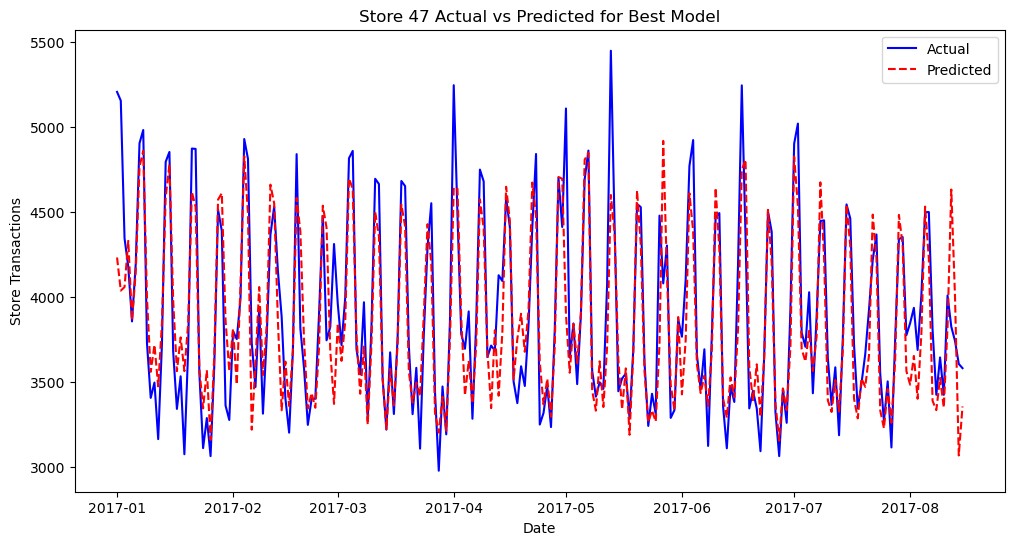

In [345]:
# Initialize parameters
n = 47
y_train = df_train.loc[df_train['store_nbr'] == n, "store_trans_filled"]
exog_train = df_train.loc[df_train['store_nbr'] == n, ["lag365", 'store_promo', 'dcoilwtico_interpolated', 'weekday', 'weekend']]
exog_test = df_test.loc[df_test['store_nbr'] == n, ["lag365", 'store_promo', 'dcoilwtico_interpolated', 'weekday', 'weekend']]
y_test = df_test.loc[df_test['store_nbr'] == n, "store_trans_filled"]

# Ensure indices are DatetimeIndex with daily frequency
y_train.index = pd.to_datetime(y_train.index).to_period('D').to_timestamp()
exog_train.index = pd.to_datetime(exog_train.index).to_period('D').to_timestamp()
y_test.index = pd.to_datetime(y_test.index).to_period('D').to_timestamp()
exog_test.index = pd.to_datetime(exog_test.index).to_period('D').to_timestamp()

d = 1 if n in [17, 20] else 0
D = 1

# Initialize best model parameters
best_model = None
best_mae = np.inf
best_predictions = None

# Define SARIMAX model with parameter grid
for p, q, P, Q in product([1,2], [1], [1], [1,2,3]):
    try:
        # Initialize and fit the SARIMAX model
        model = SARIMAX(
            y_train,
            exog=exog_train,
            order=(p, d, q),
            seasonal_order=(P, D, Q, 7)
        )
        
        results = model.fit(disp=False, maxiter=2000)
        
        # Predict values for the specified period
        predictions = results.predict(start='2017-01-01', end='2017-08-15', exog=exog_test)
        
        # Calculate Mean Absolute Error
        mae = mean_absolute_error(y_test, predictions)
        
        # Save the best model based on MAE
        if mae < best_mae:
            best_mae = mae
            best_model = model
            best_predictions = predictions
            best_pqPQ = (p, q, P, Q)  # Store the best parameters
        
    except Exception as e:
        print(f"Model with (p={p}, q={q}, P={P}, Q={Q}) failed: {e}")

# Print the best MAE and model parameters
if best_model:
    print(f'Best MAE: {best_mae:.2f}, Best MAE/MEAN: {best_mae/y_test.mean():.2f} Best (p, q, P, Q): {best_pqPQ}')
else:
    print("No valid models found.")

# Plot the real vs predicted values of the best model
if best_predictions is not None:
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='Actual', color='blue', linestyle='-')
    plt.plot(best_predictions, label='Predicted', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Store Transactions')
    plt.title(f'Store {n} Actual vs Predicted for Best Model')
    plt.legend()
    plt.show()
else:
    print("No predictions available to plot.")

# Save the best predicted result to the DataFrame
if best_predictions is not None:
    df.loc[(df['store_nbr'] == n) & (df.index.isin(best_predictions.index)), "store_trans_pred"] = best_predictions.values
else:
    print("No predictions available to save.")

In [346]:
# sanity check
df.loc[df['store_nbr'] == 47 , :].tail()

store_nbr  store_promo    year  month   day  \
date                                                      
2017-08-11         47        375.0  2017.0    8.0  11.0   
2017-08-12         47        177.0  2017.0    8.0  12.0   
2017-08-13         47        171.0  2017.0    8.0  13.0   
2017-08-14         47        160.0  2017.0    8.0  14.0   
2017-08-15         47        178.0  2017.0    8.0  15.0   

            dcoilwtico_interpolated  store_trans_filled  weekday  weekend  \
date                                                                        
2017-08-11                48.810000              4009.0      5.0      0.0   
2017-08-12                48.403333              3825.0      0.0      1.0   
2017-08-13                47.996667              3741.0      0.0      1.0   
2017-08-14                47.590000              3606.0      1.0      0.0   
2017-08-15                47.570000              3581.0      2.0      0.0   

            lag365  store_trans_pred  
date                                  
2017-08-11  3486.0       3827.998438  
2017-08-12  3910.0       4632.703704  
2017-08-13  3922.0       3998.830996  
2017-08-14  3597.0       3066.814157  
2017-08-15  3578.0       3355.502670

C:\Users\erinb\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\erinb\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\erinb\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\erinb\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\erinb\anaconda3\Lib\s

Best MAE: 201.09, Best MAE/MEAN: 0.07 Best (p, q, P, Q): (1, 4, 1, 1)


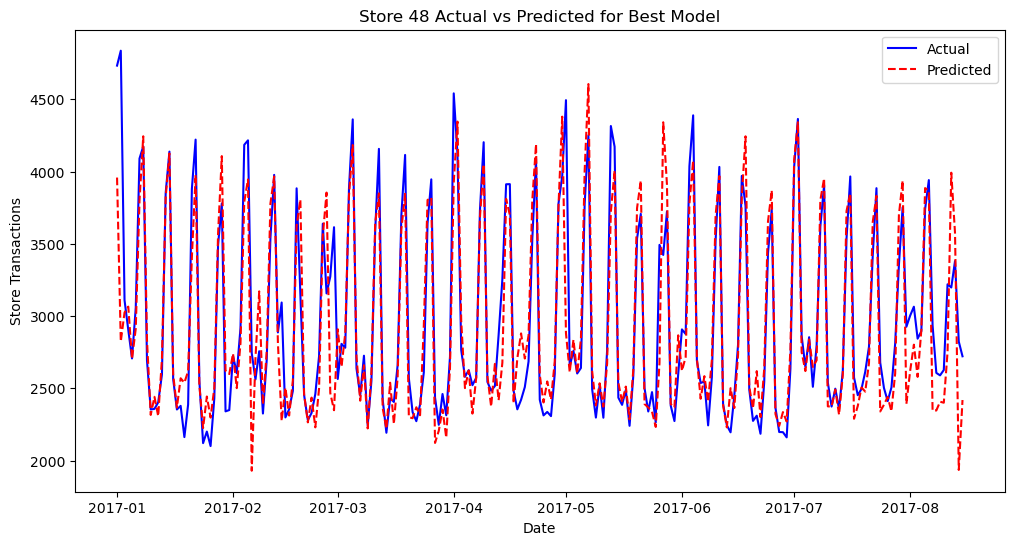

In [347]:
# Initialize parameters
n = 48
y_train = df_train.loc[df_train['store_nbr'] == n, "store_trans_filled"]
exog_train = df_train.loc[df_train['store_nbr'] == n, ["lag365", 'store_promo', 'dcoilwtico_interpolated', 'weekday', 'weekend']]
exog_test = df_test.loc[df_test['store_nbr'] == n, ["lag365", 'store_promo', 'dcoilwtico_interpolated', 'weekday', 'weekend']]
y_test = df_test.loc[df_test['store_nbr'] == n, "store_trans_filled"]

# Ensure indices are DatetimeIndex with daily frequency
y_train.index = pd.to_datetime(y_train.index).to_period('D').to_timestamp()
exog_train.index = pd.to_datetime(exog_train.index).to_period('D').to_timestamp()
y_test.index = pd.to_datetime(y_test.index).to_period('D').to_timestamp()
exog_test.index = pd.to_datetime(exog_test.index).to_period('D').to_timestamp()

d = 1 if n in [17, 20] else 0
D = 1

# Initialize best model parameters
best_model = None
best_mae = np.inf
best_predictions = None

# Define SARIMAX model with parameter grid
for p, q, P, Q in product([1,2], [1,3,4], [1,2], [1,2,3]):
    try:
        # Initialize and fit the SARIMAX model
        model = SARIMAX(
            y_train,
            exog=exog_train,
            order=(p, d, q),
            seasonal_order=(P, D, Q, 7)
        )
        
        results = model.fit(disp=False, maxiter=2000)
        
        # Predict values for the specified period
        predictions = results.predict(start='2017-01-01', end='2017-08-15', exog=exog_test)
        
        # Calculate Mean Absolute Error
        mae = mean_absolute_error(y_test, predictions)
        
        # Save the best model based on MAE
        if mae < best_mae:
            best_mae = mae
            best_model = model
            best_predictions = predictions
            best_pqPQ = (p, q, P, Q)  # Store the best parameters
        
    except Exception as e:
        print(f"Model with (p={p}, q={q}, P={P}, Q={Q}) failed: {e}")

# Print the best MAE and model parameters
if best_model:
    print(f'Best MAE: {best_mae:.2f}, Best MAE/MEAN: {best_mae/y_test.mean():.2f} Best (p, q, P, Q): {best_pqPQ}')
else:
    print("No valid models found.")

# Plot the real vs predicted values of the best model
if best_predictions is not None:
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='Actual', color='blue', linestyle='-')
    plt.plot(best_predictions, label='Predicted', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Store Transactions')
    plt.title(f'Store {n} Actual vs Predicted for Best Model')
    plt.legend()
    plt.show()
else:
    print("No predictions available to plot.")

# Save the best predicted result to the DataFrame
if best_predictions is not None:
    df.loc[(df['store_nbr'] == n) & (df.index.isin(best_predictions.index)), "store_trans_pred"] = best_predictions.values
else:
    print("No predictions available to save.")

In [348]:
# sanity check
df.loc[df['store_nbr'] == 48 , :].tail()

store_nbr  store_promo    year  month   day  \
date                                                      
2017-08-11         48        351.0  2017.0    8.0  11.0   
2017-08-12         48        166.0  2017.0    8.0  12.0   
2017-08-13         48        161.0  2017.0    8.0  13.0   
2017-08-14         48        153.0  2017.0    8.0  14.0   
2017-08-15         48        152.0  2017.0    8.0  15.0   

            dcoilwtico_interpolated  store_trans_filled  weekday  weekend  \
date                                                                        
2017-08-11                48.810000              3220.0      5.0      0.0   
2017-08-12                48.403333              3198.0      0.0      1.0   
2017-08-13                47.996667              3381.0      0.0      1.0   
2017-08-14                47.590000              2824.0      1.0      0.0   
2017-08-15                47.570000              2722.0      2.0      0.0   

            lag365  store_trans_pred  
date                                  
2017-08-11  2458.0       2751.122252  
2017-08-12  3058.0       3992.061098  
2017-08-13  3019.0       3574.046216  
2017-08-14  3059.0       1935.657247  
2017-08-15  2643.0       2419.351227

C:\Users\erinb\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model with (p=6, q=1, P=2, Q=3) failed: LU decomposition error.
Model with (p=6, q=2, P=1, Q=3) failed: LU decomposition error.
Model with (p=6, q=2, P=2, Q=2) failed: LU decomposition error.


C:\Users\erinb\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model with (p=6, q=6, P=1, Q=3) failed: LU decomposition error.
Model with (p=6, q=6, P=2, Q=3) failed: LU decomposition error.
Best MAE: 172.40, Best MAE/MEAN: 0.06 Best (p, q, P, Q): (6, 2, 1, 2)


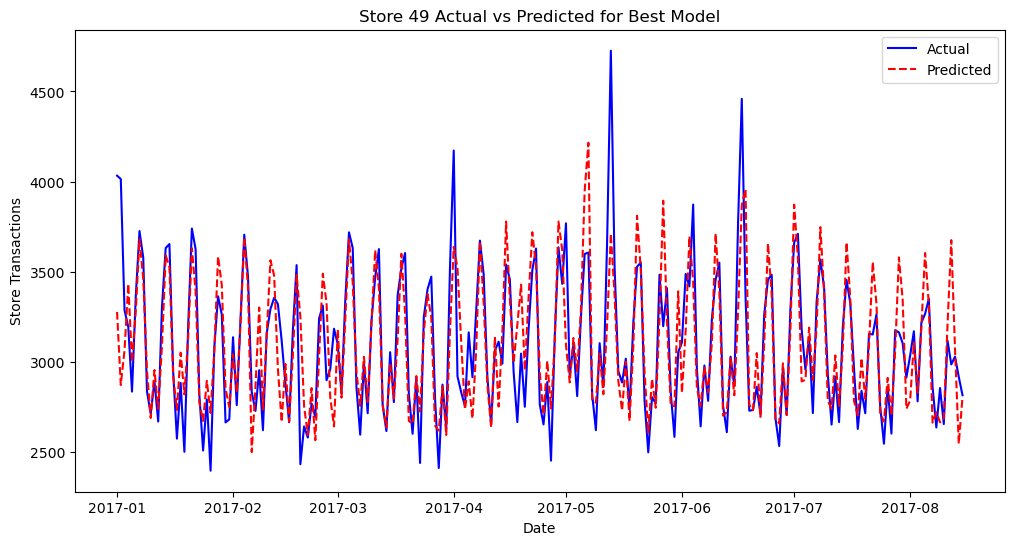

In [349]:
# Initialize parameters
n = 49
y_train = df_train.loc[df_train['store_nbr'] == n, "store_trans_filled"]
exog_train = df_train.loc[df_train['store_nbr'] == n, ["lag365", 'store_promo', 'dcoilwtico_interpolated', 'weekday', 'weekend']]
exog_test = df_test.loc[df_test['store_nbr'] == n, ["lag365", 'store_promo', 'dcoilwtico_interpolated', 'weekday', 'weekend']]
y_test = df_test.loc[df_test['store_nbr'] == n, "store_trans_filled"]

# Ensure indices are DatetimeIndex with daily frequency
y_train.index = pd.to_datetime(y_train.index).to_period('D').to_timestamp()
exog_train.index = pd.to_datetime(exog_train.index).to_period('D').to_timestamp()
y_test.index = pd.to_datetime(y_test.index).to_period('D').to_timestamp()
exog_test.index = pd.to_datetime(exog_test.index).to_period('D').to_timestamp()

d = 1 if n in [17, 20] else 0
D = 1

# Initialize best model parameters
best_model = None
best_mae = np.inf
best_predictions = None

# Define SARIMAX model with parameter grid
for p, q, P, Q in product([1,6], [1,2,6], [1,2], [1,2,3]):
    try:
        # Initialize and fit the SARIMAX model
        model = SARIMAX(
            y_train,
            exog=exog_train,
            order=(p, d, q),
            seasonal_order=(P, D, Q, 7)
        )
        
        results = model.fit(disp=False, maxiter=2000)
        
        # Predict values for the specified period
        predictions = results.predict(start='2017-01-01', end='2017-08-15', exog=exog_test)
        
        # Calculate Mean Absolute Error
        mae = mean_absolute_error(y_test, predictions)
        
        # Save the best model based on MAE
        if mae < best_mae:
            best_mae = mae
            best_model = model
            best_predictions = predictions
            best_pqPQ = (p, q, P, Q)  # Store the best parameters
        
    except Exception as e:
        print(f"Model with (p={p}, q={q}, P={P}, Q={Q}) failed: {e}")

# Print the best MAE and model parameters
if best_model:
    print(f'Best MAE: {best_mae:.2f}, Best MAE/MEAN: {best_mae/y_test.mean():.2f} Best (p, q, P, Q): {best_pqPQ}')
else:
    print("No valid models found.")

# Plot the real vs predicted values of the best model
if best_predictions is not None:
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='Actual', color='blue', linestyle='-')
    plt.plot(best_predictions, label='Predicted', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Store Transactions')
    plt.title(f'Store {n} Actual vs Predicted for Best Model')
    plt.legend()
    plt.show()
else:
    print("No predictions available to plot.")

# Save the best predicted result to the DataFrame
if best_predictions is not None:
    df.loc[(df['store_nbr'] == n) & (df.index.isin(best_predictions.index)), "store_trans_pred"] = best_predictions.values
else:
    print("No predictions available to save.")

In [350]:
# sanity check
df.loc[df['store_nbr'] == 49 , :].tail()

store_nbr  store_promo    year  month   day  \
date                                                      
2017-08-11         49        374.0  2017.0    8.0  11.0   
2017-08-12         49        172.0  2017.0    8.0  12.0   
2017-08-13         49        177.0  2017.0    8.0  13.0   
2017-08-14         49        168.0  2017.0    8.0  14.0   
2017-08-15         49        168.0  2017.0    8.0  15.0   

            dcoilwtico_interpolated  store_trans_filled  weekday  weekend  \
date                                                                        
2017-08-11                48.810000              3117.0      5.0      0.0   
2017-08-12                48.403333              2985.0      0.0      1.0   
2017-08-13                47.996667              3028.0      0.0      1.0   
2017-08-14                47.590000              2916.0      1.0      0.0   
2017-08-15                47.570000              2814.0      2.0      0.0   

            lag365  store_trans_pred  
date                                  
2017-08-11  2645.0       3208.856525  
2017-08-12  3093.0       3674.841415  
2017-08-13  2835.0       3069.097549  
2017-08-14  2841.0       2544.683293  
2017-08-15  2831.0       2804.096459

Best MAE: 99.60, Best MAE/MEAN: 0.06 Best (p, q, P, Q): (6, 1, 2, 2)


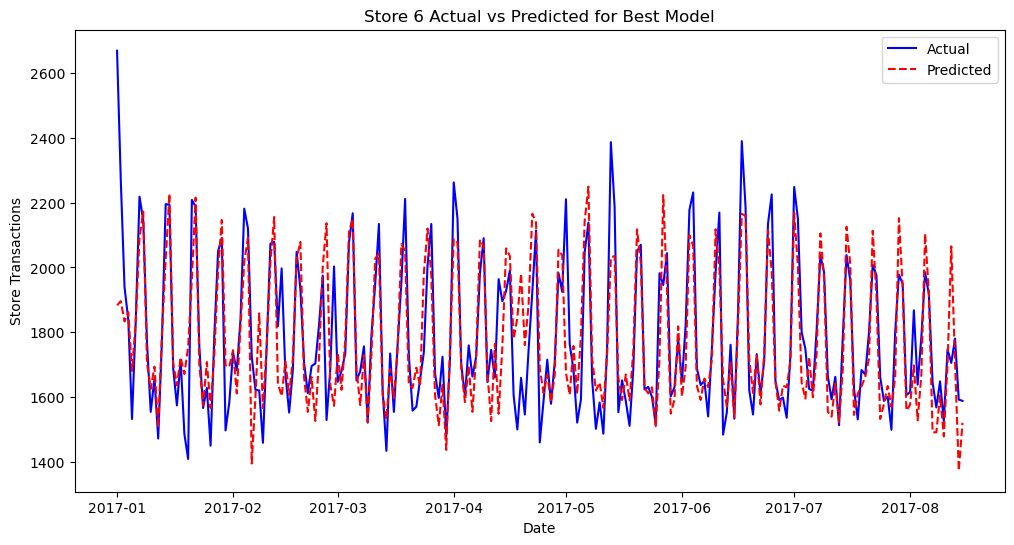

In [351]:
# Initialize parameters
n = 6
y_train = df_train.loc[df_train['store_nbr'] == n, "store_trans_filled"]
exog_train = df_train.loc[df_train['store_nbr'] == n, ["lag365", 'store_promo', 'dcoilwtico_interpolated', 'weekday', 'weekend']]
exog_test = df_test.loc[df_test['store_nbr'] == n, ["lag365", 'store_promo', 'dcoilwtico_interpolated', 'weekday', 'weekend']]
y_test = df_test.loc[df_test['store_nbr'] == n, "store_trans_filled"]

# Ensure indices are DatetimeIndex with daily frequency
y_train.index = pd.to_datetime(y_train.index).to_period('D').to_timestamp()
exog_train.index = pd.to_datetime(exog_train.index).to_period('D').to_timestamp()
y_test.index = pd.to_datetime(y_test.index).to_period('D').to_timestamp()
exog_test.index = pd.to_datetime(exog_test.index).to_period('D').to_timestamp()

d = 1 if n in [17, 20] else 0
D = 1

# Initialize best model parameters
best_model = None
best_mae = np.inf
best_predictions = None

# Define SARIMAX model with parameter grid
for p, q, P, Q in product([1,2,6], [1], [1,2], [1,2]):
    try:
        # Initialize and fit the SARIMAX model
        model = SARIMAX(
            y_train,
            exog=exog_train,
            order=(p, d, q),
            seasonal_order=(P, D, Q, 7)
        )
        
        results = model.fit(disp=False, maxiter=2000)
        
        # Predict values for the specified period
        predictions = results.predict(start='2017-01-01', end='2017-08-15', exog=exog_test)
        
        # Calculate Mean Absolute Error
        mae = mean_absolute_error(y_test, predictions)
        
        # Save the best model based on MAE
        if mae < best_mae:
            best_mae = mae
            best_model = model
            best_predictions = predictions
            best_pqPQ = (p, q, P, Q)  # Store the best parameters
        
    except Exception as e:
        print(f"Model with (p={p}, q={q}, P={P}, Q={Q}) failed: {e}")

# Print the best MAE and model parameters
if best_model:
    print(f'Best MAE: {best_mae:.2f}, Best MAE/MEAN: {best_mae/y_test.mean():.2f} Best (p, q, P, Q): {best_pqPQ}')
else:
    print("No valid models found.")

# Plot the real vs predicted values of the best model
if best_predictions is not None:
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='Actual', color='blue', linestyle='-')
    plt.plot(best_predictions, label='Predicted', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Store Transactions')
    plt.title(f'Store {n} Actual vs Predicted for Best Model')
    plt.legend()
    plt.show()
else:
    print("No predictions available to plot.")

# Save the best predicted result to the DataFrame
if best_predictions is not None:
    df.loc[(df['store_nbr'] == n) & (df.index.isin(best_predictions.index)), "store_trans_pred"] = best_predictions.values
else:
    print("No predictions available to save.")

In [352]:
# sanity check
df.loc[df['store_nbr'] == 6 , :].tail()

store_nbr  store_promo    year  month   day  \
date                                                      
2017-08-11          6        333.0  2017.0    8.0  11.0   
2017-08-12          6        142.0  2017.0    8.0  12.0   
2017-08-13          6        138.0  2017.0    8.0  13.0   
2017-08-14          6        129.0  2017.0    8.0  14.0   
2017-08-15          6        135.0  2017.0    8.0  15.0   

            dcoilwtico_interpolated  store_trans_filled  weekday  weekend  \
date                                                                        
2017-08-11                48.810000              1747.0      5.0      0.0   
2017-08-12                48.403333              1706.0      0.0      1.0   
2017-08-13                47.996667              1781.0      0.0      1.0   
2017-08-14                47.590000              1593.0      1.0      0.0   
2017-08-15                47.570000              1589.0      2.0      0.0   

            lag365  store_trans_pred  
date                                  
2017-08-11  1549.0       1702.289044  
2017-08-12  1719.0       2064.665518  
2017-08-13  1545.0       1711.524646  
2017-08-14  1627.0       1373.892241  
2017-08-15  1601.0       1521.584194

Best MAE: 89.78, Best MAE/MEAN: 0.05 Best (p, q, P, Q): (1, 1, 1, 2)


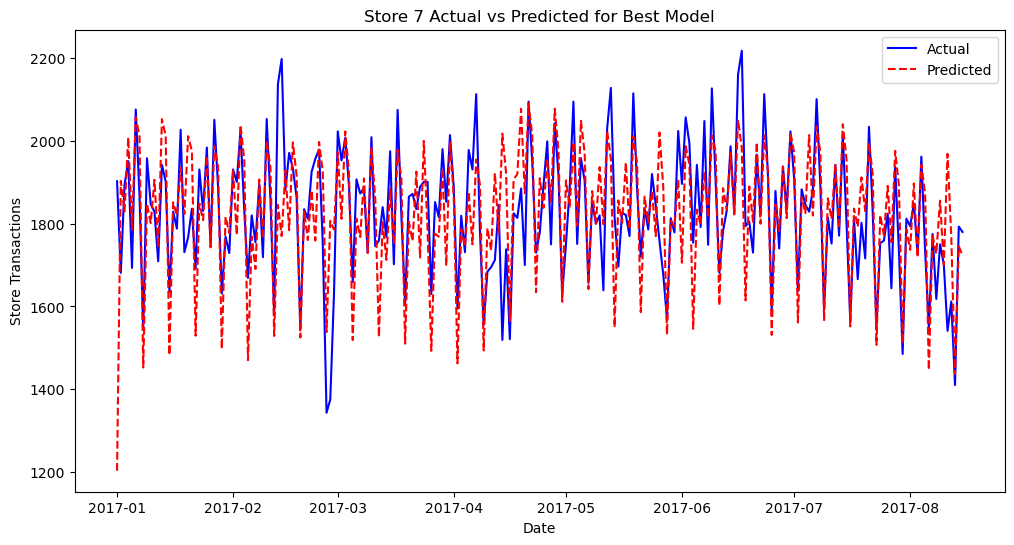

In [353]:
# Initialize parameters
n = 7
y_train = df_train.loc[df_train['store_nbr'] == n, "store_trans_filled"]
exog_train = df_train.loc[df_train['store_nbr'] == n, ["lag365", 'store_promo', 'dcoilwtico_interpolated', 'weekday', 'weekend']]
exog_test = df_test.loc[df_test['store_nbr'] == n, ["lag365", 'store_promo', 'dcoilwtico_interpolated', 'weekday', 'weekend']]
y_test = df_test.loc[df_test['store_nbr'] == n, "store_trans_filled"]

# Ensure indices are DatetimeIndex with daily frequency
y_train.index = pd.to_datetime(y_train.index).to_period('D').to_timestamp()
exog_train.index = pd.to_datetime(exog_train.index).to_period('D').to_timestamp()
y_test.index = pd.to_datetime(y_test.index).to_period('D').to_timestamp()
exog_test.index = pd.to_datetime(exog_test.index).to_period('D').to_timestamp()

d = 1 if n in [17, 20] else 0
D = 1

# Initialize best model parameters
best_model = None
best_mae = np.inf
best_predictions = None

# Define SARIMAX model with parameter grid
for p, q, P, Q in product([1], [1], [1,2], [1,2]):
    try:
        # Initialize and fit the SARIMAX model
        model = SARIMAX(
            y_train,
            exog=exog_train,
            order=(p, d, q),
            seasonal_order=(P, D, Q, 7)
        )
        
        results = model.fit(disp=False, maxiter=2000)
        
        # Predict values for the specified period
        predictions = results.predict(start='2017-01-01', end='2017-08-15', exog=exog_test)
        
        # Calculate Mean Absolute Error
        mae = mean_absolute_error(y_test, predictions)
        
        # Save the best model based on MAE
        if mae < best_mae:
            best_mae = mae
            best_model = model
            best_predictions = predictions
            best_pqPQ = (p, q, P, Q)  # Store the best parameters
        
    except Exception as e:
        print(f"Model with (p={p}, q={q}, P={P}, Q={Q}) failed: {e}")

# Print the best MAE and model parameters
if best_model:
    print(f'Best MAE: {best_mae:.2f}, Best MAE/MEAN: {best_mae/y_test.mean():.2f} Best (p, q, P, Q): {best_pqPQ}')
else:
    print("No valid models found.")

# Plot the real vs predicted values of the best model
if best_predictions is not None:
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='Actual', color='blue', linestyle='-')
    plt.plot(best_predictions, label='Predicted', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Store Transactions')
    plt.title(f'Store {n} Actual vs Predicted for Best Model')
    plt.legend()
    plt.show()
else:
    print("No predictions available to plot.")

# Save the best predicted result to the DataFrame
if best_predictions is not None:
    df.loc[(df['store_nbr'] == n) & (df.index.isin(best_predictions.index)), "store_trans_pred"] = best_predictions.values
else:
    print("No predictions available to save.")

In [354]:
# sanity check
df.loc[df['store_nbr'] == 7 , :].tail()

store_nbr  store_promo    year  month   day  \
date                                                      
2017-08-11          7        300.0  2017.0    8.0  11.0   
2017-08-12          7        122.0  2017.0    8.0  12.0   
2017-08-13          7        121.0  2017.0    8.0  13.0   
2017-08-14          7        126.0  2017.0    8.0  14.0   
2017-08-15          7        130.0  2017.0    8.0  15.0   

            dcoilwtico_interpolated  store_trans_filled  weekday  weekend  \
date                                                                        
2017-08-11                48.810000              1541.0      5.0      0.0   
2017-08-12                48.403333              1612.0      0.0      1.0   
2017-08-13                47.996667              1410.0      0.0      1.0   
2017-08-14                47.590000              1793.0      1.0      0.0   
2017-08-15                47.570000              1780.0      2.0      0.0   

            lag365  store_trans_pred  
date                                  
2017-08-11  1715.0       1968.632261  
2017-08-12  1472.0       1767.642368  
2017-08-13  1563.0       1435.942239  
2017-08-14  1352.0       1745.523264  
2017-08-15  1646.0       1722.946922

C:\Users\erinb\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\erinb\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\erinb\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\erinb\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Best MAE: 124.38, Best MAE/MEAN: 0.05 Best (p, q, P, Q): (1, 1, 1, 2)


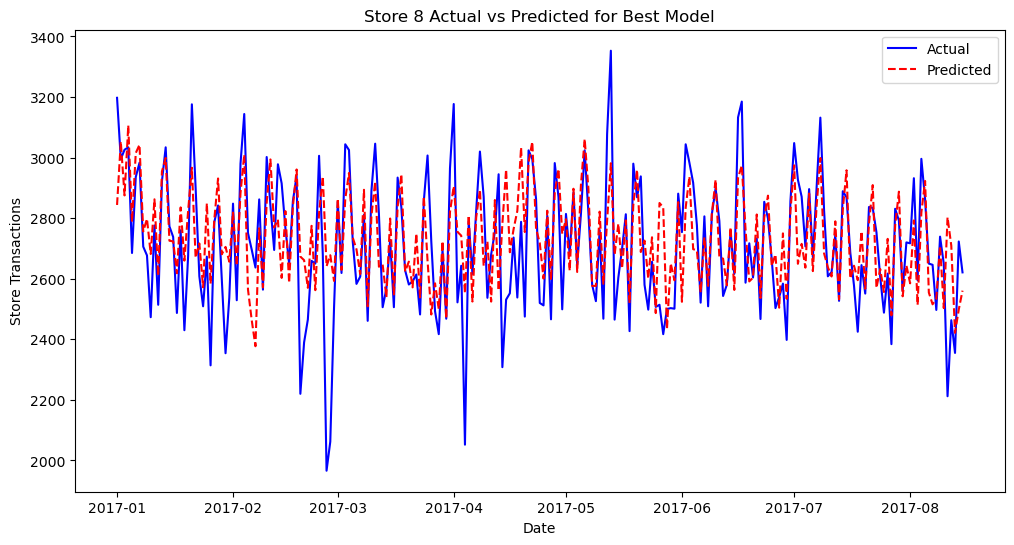

In [355]:
# Initialize parameters
n = 8
y_train = df_train.loc[df_train['store_nbr'] == n, "store_trans_filled"]
exog_train = df_train.loc[df_train['store_nbr'] == n, ["lag365", 'store_promo', 'dcoilwtico_interpolated', 'weekday', 'weekend']]
exog_test = df_test.loc[df_test['store_nbr'] == n, ["lag365", 'store_promo', 'dcoilwtico_interpolated', 'weekday', 'weekend']]
y_test = df_test.loc[df_test['store_nbr'] == n, "store_trans_filled"]

# Ensure indices are DatetimeIndex with daily frequency
y_train.index = pd.to_datetime(y_train.index).to_period('D').to_timestamp()
exog_train.index = pd.to_datetime(exog_train.index).to_period('D').to_timestamp()
y_test.index = pd.to_datetime(y_test.index).to_period('D').to_timestamp()
exog_test.index = pd.to_datetime(exog_test.index).to_period('D').to_timestamp()

d = 1 if n in [17, 20] else 0
D = 1

# Initialize best model parameters
best_model = None
best_mae = np.inf
best_predictions = None

# Define SARIMAX model with parameter grid
for p, q, P, Q in product([1], [1,2,3], [1], [1,2]):
    try:
        # Initialize and fit the SARIMAX model
        model = SARIMAX(
            y_train,
            exog=exog_train,
            order=(p, d, q),
            seasonal_order=(P, D, Q, 7)
        )
        
        results = model.fit(disp=False, maxiter=2000)
        
        # Predict values for the specified period
        predictions = results.predict(start='2017-01-01', end='2017-08-15', exog=exog_test)
        
        # Calculate Mean Absolute Error
        mae = mean_absolute_error(y_test, predictions)
        
        # Save the best model based on MAE
        if mae < best_mae:
            best_mae = mae
            best_model = model
            best_predictions = predictions
            best_pqPQ = (p, q, P, Q)  # Store the best parameters
        
    except Exception as e:
        print(f"Model with (p={p}, q={q}, P={P}, Q={Q}) failed: {e}")

# Print the best MAE and model parameters
if best_model:
    print(f'Best MAE: {best_mae:.2f}, Best MAE/MEAN: {best_mae/y_test.mean():.2f} Best (p, q, P, Q): {best_pqPQ}')
else:
    print("No valid models found.")

# Plot the real vs predicted values of the best model
if best_predictions is not None:
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='Actual', color='blue', linestyle='-')
    plt.plot(best_predictions, label='Predicted', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Store Transactions')
    plt.title(f'Store {n} Actual vs Predicted for Best Model')
    plt.legend()
    plt.show()
else:
    print("No predictions available to plot.")

# Save the best predicted result to the DataFrame
if best_predictions is not None:
    df.loc[(df['store_nbr'] == n) & (df.index.isin(best_predictions.index)), "store_trans_pred"] = best_predictions.values
else:
    print("No predictions available to save.")

In [356]:
# sanity check
df.loc[df['store_nbr'] == 8 , :].tail()

store_nbr  store_promo    year  month   day  \
date                                                      
2017-08-11          8        339.0  2017.0    8.0  11.0   
2017-08-12          8        143.0  2017.0    8.0  12.0   
2017-08-13          8        140.0  2017.0    8.0  13.0   
2017-08-14          8        141.0  2017.0    8.0  14.0   
2017-08-15          8        137.0  2017.0    8.0  15.0   

            dcoilwtico_interpolated  store_trans_filled  weekday  weekend  \
date                                                                        
2017-08-11                48.810000              2212.0      5.0      0.0   
2017-08-12                48.403333              2463.0      0.0      1.0   
2017-08-13                47.996667              2355.0      0.0      1.0   
2017-08-14                47.590000              2723.0      1.0      0.0   
2017-08-15                47.570000              2621.0      2.0      0.0   

            lag365  store_trans_pred  
date                                  
2017-08-11  2480.0       2803.042380  
2017-08-12  2299.0       2709.348965  
2017-08-13  2358.0       2421.365390  
2017-08-14  2240.0       2498.193156  
2017-08-15  2633.0       2560.646950

C:\Users\erinb\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Best MAE: 137.64, Best MAE/MEAN: 0.07 Best (p, q, P, Q): (1, 2, 2, 2)


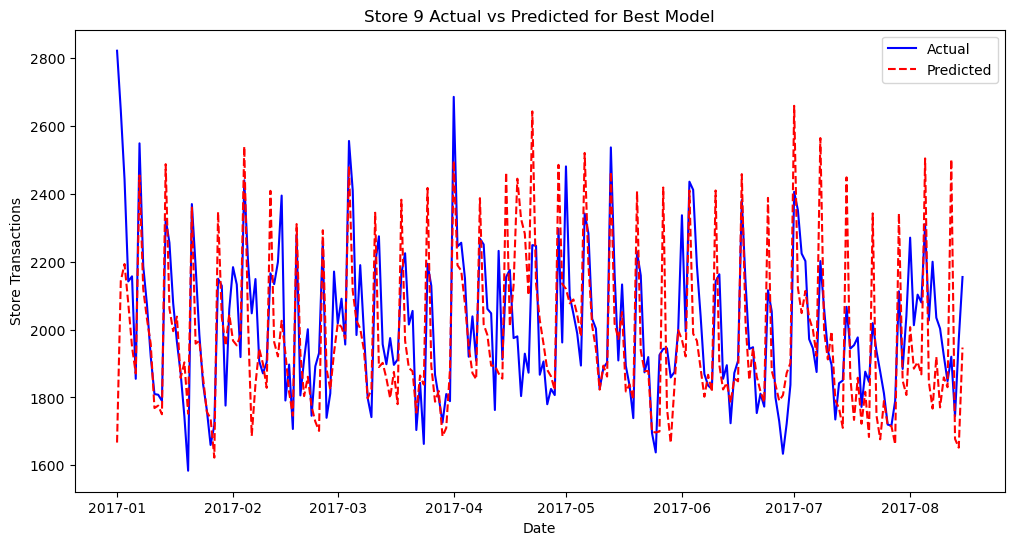

In [360]:
# Initialize parameters
n = 9
y_train = df_train.loc[df_train['store_nbr'] == n, "store_trans_filled"]
exog_train = df_train.loc[df_train['store_nbr'] == n, ["lag365", 'store_promo', 'dcoilwtico_interpolated', 'weekday', 'weekend']]
exog_test = df_test.loc[df_test['store_nbr'] == n, ["lag365", 'store_promo', 'dcoilwtico_interpolated', 'weekday', 'weekend']]
y_test = df_test.loc[df_test['store_nbr'] == n, "store_trans_filled"]

# Ensure indices are DatetimeIndex with daily frequency
y_train.index = pd.to_datetime(y_train.index).to_period('D').to_timestamp()
exog_train.index = pd.to_datetime(exog_train.index).to_period('D').to_timestamp()
y_test.index = pd.to_datetime(y_test.index).to_period('D').to_timestamp()
exog_test.index = pd.to_datetime(exog_test.index).to_period('D').to_timestamp()

d = 1 if n in [17, 20] else 0
D = 1

# Initialize best model parameters
best_model = None
best_mae = np.inf
best_predictions = None

# Define SARIMAX model with parameter grid
for p, q, P, Q in product([1], [1,2], [1,2], [1,2,3]):
    try:
        # Initialize and fit the SARIMAX model
        model = SARIMAX(
            y_train,
            exog=exog_train,
            order=(p, d, q),
            seasonal_order=(P, D, Q, 7)
        )
        
        results = model.fit(disp=False, maxiter=4000)
        
        # Predict values for the specified period
        predictions = results.predict(start='2017-01-01', end='2017-08-15', exog=exog_test)
        
        # Calculate Mean Absolute Error
        mae = mean_absolute_error(y_test, predictions)
        
        # Save the best model based on MAE
        if mae < best_mae:
            best_mae = mae
            best_model = model
            best_predictions = predictions
            best_pqPQ = (p, q, P, Q)  # Store the best parameters
        
    except Exception as e:
        print(f"Model with (p={p}, q={q}, P={P}, Q={Q}) failed: {e}")

# Print the best MAE and model parameters
if best_model:
    print(f'Best MAE: {best_mae:.2f}, Best MAE/MEAN: {best_mae/y_test.mean():.2f} Best (p, q, P, Q): {best_pqPQ}')
else:
    print("No valid models found.")

# Plot the real vs predicted values of the best model
if best_predictions is not None:
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='Actual', color='blue', linestyle='-')
    plt.plot(best_predictions, label='Predicted', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Store Transactions')
    plt.title(f'Store {n} Actual vs Predicted for Best Model')
    plt.legend()
    plt.show()
else:
    print("No predictions available to plot.")

# Save the best predicted result to the DataFrame
if best_predictions is not None:
    df.loc[(df['store_nbr'] == n) & (df.index.isin(best_predictions.index)), "store_trans_pred"] = best_predictions.values
else:
    print("No predictions available to save.")

In [361]:
# sanity check
df.loc[df['store_nbr'] == 9 , :].tail()

store_nbr  store_promo    year  month   day  \
date                                                      
2017-08-11          9        279.0  2017.0    8.0  11.0   
2017-08-12          9        214.0  2017.0    8.0  12.0   
2017-08-13          9        261.0  2017.0    8.0  13.0   
2017-08-14          9        203.0  2017.0    8.0  14.0   
2017-08-15          9        331.0  2017.0    8.0  15.0   

            dcoilwtico_interpolated  store_trans_filled  weekday  weekend  \
date                                                                        
2017-08-11                48.810000              1848.0      5.0      0.0   
2017-08-12                48.403333              1920.0      0.0      1.0   
2017-08-13                47.996667              1745.0      0.0      1.0   
2017-08-14                47.590000              1971.0      1.0      0.0   
2017-08-15                47.570000              2155.0      2.0      0.0   

            lag365  store_trans_pred  
date                                  
2017-08-11  1887.0       1830.156209  
2017-08-12  1976.0       2501.843812  
2017-08-13  1882.0       1677.905683  
2017-08-14  1812.0       1652.007902  
2017-08-15  1999.0       1947.103475

In [364]:
df.count()

store_nbr                  21702
store_promo                21702
year                       21702
month                      21702
day                        21702
dcoilwtico_interpolated    21702
store_trans_filled         21702
weekday                    21702
weekend                    21702
lag365                     21702
store_trans_pred            3859
dtype: int64

In [397]:
df.to_csv('df_store_trans_pred.csv')

In [400]:
df_pred = pd.read_csv('df_store_trans_pred.csv', index_col='date')
df_pred

store_nbr  store_promo    year  month   day  \
date                                                      
2014-01-02          1          0.0  2014.0    1.0   2.0   
2014-01-03          1          0.0  2014.0    1.0   3.0   
2014-01-04          1          0.0  2014.0    1.0   4.0   
2014-01-05          1          0.0  2014.0    1.0   5.0   
2014-01-06          1          0.0  2014.0    1.0   6.0   
...               ...          ...     ...    ...   ...   
2017-08-11          9        279.0  2017.0    8.0  11.0   
2017-08-12          9        214.0  2017.0    8.0  12.0   
2017-08-13          9        261.0  2017.0    8.0  13.0   
2017-08-14          9        203.0  2017.0    8.0  14.0   
2017-08-15          9        331.0  2017.0    8.0  15.0   

            dcoilwtico_interpolated  store_trans_filled  weekday  weekend  \
date                                                                        
2014-01-02                95.140000              1875.0      4.0      0.0   
2014-01-03                93.660000              1817.0      5.0      0.0   
2014-01-04                93.480000              1294.0      0.0      1.0   
2014-01-05                93.300000               489.0      0.0      1.0   
2014-01-06                93.120000              1754.0      1.0      0.0   
...                             ...                 ...      ...      ...   
2017-08-11                48.810000              1848.0      5.0      0.0   
2017-08-12                48.403333              1920.0      0.0      1.0   
2017-08-13                47.996667              1745.0      0.0      1.0   
2017-08-14                47.590000              1971.0      1.0      0.0   
2017-08-15                47.570000              2155.0      2.0      0.0   

            lag365  store_trans_pred  
date                                  
2014-01-02  2111.0               NaN  
2014-01-03  1833.0               NaN  
2014-01-04  1863.0               NaN  
2014-01-05  1509.0               NaN  
2014-01-06   520.0               NaN  
...            ...               ...  
2017-08-11  1887.0       1830.156209  
2017-08-12  1976.0       2501.843812  
2017-08-13  1882.0       1677.905683  
2017-08-14  1812.0       1652.007902  
2017-08-15  1999.0       1947.103475  

[21702 rows x 11 columns]